In [66]:
# Model Training for MMASH Dataset Analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import pickle
import os

# for modeling
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold, StratifiedKFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.inspection import permutation_importance
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
import xgboost as xgb

# for visualization
from plotnine import *
from skmisc.loess import loess
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
plt.style.use('seaborn-v0_8-pastel')
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_context("notebook", font_scale=1.5)


# load the preprocessed data
with open('mmash_preprocessed_data.pkl', 'rb') as f:
    data = pickle.load(f)

print("preprocessed data loaded successfully")

preprocessed data loaded successfully


In [67]:
# Data Exploration and Feature Engineering
# check what is available in the preprocessed data
print("keys in preprocessed data:")
for key in data.keys():
    print(f"- {key}")

# explore the combined data structure
combined_data = data['combined']
print("\ncombined data contains:")
for key, df in combined_data.items():
    if isinstance(df, pd.DataFrame):
        print(f"- {key}: {df.shape[0]} rows × {df.shape[1]} columns")

# individual user data
individual_data = data['individual']
print(f"\nindividual data contains info for {len(individual_data)} users")

# first, let's identify suitable metrics for our analysis
# 1. sleep quality metrics
if 'sleep' in combined_data and not combined_data['sleep'].empty:
    sleep_df = combined_data['sleep']
    print("\nsleep data columns:")
    for col in sleep_df.columns:
        print(f"- {col}")
    
    # identify potential sleep quality metrics
    sleep_quality_metrics = []
    for col in sleep_df.columns:
        col_lower = col.lower()
        if any(term in col_lower for term in ['efficiency', 'quality', 'tst', 'sleep time', 'awakenings']):
            sleep_quality_metrics.append(col)
    
    print("\npotential sleep quality metrics:")
    for metric in sleep_quality_metrics:
        non_null = sleep_df[metric].count()
        print(f"- {metric}: {non_null} non-null values")

# 2. heart rate metrics
hrv_metrics = []
if 'hrv_features' in combined_data and not combined_data['hrv_features'].empty:
    hrv_df = combined_data['hrv_features']
    print("\nhrv features columns:")
    for col in hrv_df.columns:
        print(f"- {col}")
    hrv_metrics = [col for col in hrv_df.columns if col != 'timestamp']

# 3. activity data (for screen time)
if 'activity' in combined_data and not combined_data['activity'].empty:
    activity_df = combined_data['activity']
    print("\nactivity data columns:")
    for col in activity_df.columns:
        print(f"- {col}")
    
    # check if we have screen time activity
    if 'activity_name' in activity_df.columns:
        screen_activities = activity_df[activity_df['activity_name'].isin(['small_screen_usage', 'large_screen_usage'])]
        print(f"\nfound {len(screen_activities)} screen time activities")

keys in preprocessed data:
- combined
- individual
- missing_values

combined data contains:
- user_info: 22 rows × 6 columns
- sleep: 22 rows × 23 columns
- rr: 1749295 rows × 5 columns
- hrv_features: 310 rows × 5 columns
- questionnaire: 22 rows × 21 columns
- activity: 456 rows × 10 columns
- actigraph: 220000 rows × 17 columns
- saliva: 42 rows × 5 columns

individual data contains info for 22 users

sleep data columns:
- Unnamed: 0
- In Bed Date
- In Bed Time
- Out Bed Date
- Out Bed Time
- Onset Date
- Onset Time
- Latency
- Efficiency
- Total Minutes in Bed
- Total Sleep Time (TST)
- Wake After Sleep Onset (WASO)
- Number of Awakenings
- Average Awakening Length
- Movement Index
- Fragmentation Index
- Sleep Fragmentation Index
- user_id
- in bed time_datetime
- out bed time_datetime
- onset time_datetime
- sleep_duration_hours
- sleep_efficiency

potential sleep quality metrics:
- Efficiency: 22 non-null values
- Total Sleep Time (TST): 22 non-null values
- Number of Awakening

In [68]:
# Feature Engineering and Dataset Preparation
# Function to extract daily metrics
def extract_daily_metrics(data):
    """
    extracts daily metrics for each user:
    - sleep quality metrics
    - average daily heart rate metrics
    - daily screen time in minutes
    
    returns a dataframe with one row per user-day
    """
    daily_metrics = []
    screen_time_debug = []  # For debugging screen time calculations
    
    # process each user's data
    for user_data in data['individual']:
        user_id = None
        
        # extract user_id from any available dataframe
        for df_name, df in user_data.items():
            if isinstance(df, pd.DataFrame) and not df.empty and 'user_id' in df.columns:
                user_id = df['user_id'].iloc[0]
                break
        
        if user_id is None:
            continue
        
        # 1. extract sleep metrics
        if 'sleep' in user_data and not user_data['sleep'].empty:
            sleep_df = user_data['sleep']
            
            # for each day in sleep data
            for _, sleep_row in sleep_df.iterrows():
                day_metrics = {'user_id': user_id}
                
                # get date
                date_col = None
                for col in sleep_df.columns:
                    if 'date' in col.lower() and 'onset' in col.lower():
                        date_col = col
                        break
                
                if date_col is None:
                    for col in sleep_df.columns:
                        if 'date' in col.lower():
                            date_col = col
                            break
                
                if date_col:
                    day_metrics['date'] = sleep_row[date_col]
                
                # extract sleep quality metrics
                for col in sleep_quality_metrics:
                    if col in sleep_df.columns:
                        day_metrics[f'sleep_{col}'] = sleep_row[col]
                
                # 2. extract heart rate metrics for the same day
                if 'hrv_features' in user_data and not user_data['hrv_features'].empty:
                    hrv_df = user_data['hrv_features']
                    
                    # filter hrv features for this day
                    day_hrv = None
                    if 'timestamp' in hrv_df.columns:
                        if date_col and 'date' in day_metrics:
                            # convert timestamp to date string for comparison
                            hrv_df['date_str'] = hrv_df['timestamp'].dt.strftime('%Y-%m-%d')
                            day_string = str(day_metrics['date'])
                            day_hrv = hrv_df[hrv_df['date_str'] == day_string]
                    
                    if day_hrv is not None and not day_hrv.empty:
                        # calculate daily averages for hrv metrics
                        for metric in hrv_metrics:
                            if metric != 'timestamp':
                                day_metrics[f'hrv_{metric}'] = day_hrv[metric].mean()
                
                # 3. extract screen time - ADJUSTED TO CHECK PREVIOUS DAY
                if 'activity' in user_data and not user_data['activity'].empty:
                    activity_df = user_data['activity']
                    
                    if 'Day' in activity_df.columns:
                        # Important: Based on the debug output, we need to check the PREVIOUS day
                        # from the sleep data since sleep is recorded on day N but screen time happens on day N-1
                        
                        # Get current date from sleep
                        sleep_day = 0
                        if 'date' in day_metrics:
                            try:
                                sleep_day = int(day_metrics['date'])
                            except:
                                pass
                        
                        # Look for screen activities from previous day
                        screen_day = sleep_day - 1
                        
                        # Make sure we don't go below day 1
                        if screen_day >= 1:
                            # Get all screen activities for the day
                            day_activity = activity_df[activity_df['Day'] == screen_day]
                            
                            if not day_activity.empty:
                                screen_rows = day_activity[day_activity['Activity'].isin([8, 9])]
                                
                                if not screen_rows.empty and 'duration_minutes' in screen_rows.columns:
                                    screen_time = screen_rows['duration_minutes'].sum()
                                    day_metrics['screen_time_minutes'] = screen_time
                                    
                                    # Add debug info
                                    screen_time_debug.append({
                                        'user_id': user_id,
                                        'sleep_day': sleep_day,
                                        'screen_day': screen_day,
                                        'screen_time': screen_time
                                    })
                                else:
                                    day_metrics['screen_time_minutes'] = 0.0
                            else:
                                day_metrics['screen_time_minutes'] = 0.0
                        else:
                            day_metrics['screen_time_minutes'] = 0.0
                
                daily_metrics.append(day_metrics)
    
    # convert to dataframe
    metrics_df = pd.DataFrame(daily_metrics)
    
    # Convert debug info to dataframe
    screen_debug_df = pd.DataFrame(screen_time_debug)
    
    return metrics_df, screen_debug_df

# extract daily metrics
print("\nextracting daily metrics for each user...")
daily_metrics_df, screen_debug_df = extract_daily_metrics(data)
print(f"extracted metrics for {len(daily_metrics_df)} user-days")

# display screen time debug info
print("\nScreen time calculation debug info:")
if not screen_debug_df.empty:
    display(screen_debug_df)
    
    # Show statistics
    print(f"\nUsers with non-zero screen time: {len(screen_debug_df[screen_debug_df['screen_time'] > 0])}")
    print(f"Average screen time (where available): {screen_debug_df['screen_time'].mean():.1f} minutes")
else:
    print("No screen time data was found with the adjustment.")

# display the first few rows of the metrics
print("\ndaily metrics preview:")
display(daily_metrics_df.head())

# check for missing values
missing_values = daily_metrics_df.isnull().sum()
print("\nmissing values in daily metrics:")
for col, missing in missing_values.items():
    if missing > 0:
        print(f"- {col}: {missing} missing values ({missing / len(daily_metrics_df) * 100:.1f}%)")

# fill missing values or drop rows with too many missing values
# for this analysis, we'll require sleep metrics and at least some hrv metrics
req_cols = [col for col in daily_metrics_df.columns if col.startswith('sleep_') or col.startswith('hrv_')]
if req_cols:
    # drop rows where all required columns are missing
    daily_metrics_df = daily_metrics_df.dropna(subset=req_cols, how='all')
    print(f"\nafter dropping rows with missing key metrics: {len(daily_metrics_df)} rows remaining")

    # for remaining missing values, fill with median
    for col in daily_metrics_df.columns:
        if daily_metrics_df[col].isnull().sum() > 0:
            if daily_metrics_df[col].dtype in [np.float64, np.int64]:
                median_val = daily_metrics_df[col].median()
                daily_metrics_df[col] = daily_metrics_df[col].fillna(median_val)

# calculate stress index from HRV metrics if available
if 'hrv_sdnn' in daily_metrics_df.columns and 'hrv_rmssd' in daily_metrics_df.columns:
    # stress index can be approximated as inverse of HRV
    # lower HRV (sdnn/rmssd) = higher stress
    daily_metrics_df['stress_index'] = 100 / (daily_metrics_df['hrv_sdnn'] + 1)  # +1 to avoid division by zero
    print("\nstress index calculated from hrv metrics")

# select target variable (sleep quality metric)
# look for the most complete sleep quality metric
sleep_cols = [col for col in daily_metrics_df.columns if col.startswith('sleep_')]
if sleep_cols:
    non_null_counts = daily_metrics_df[sleep_cols].count()
    target_col = non_null_counts.idxmax()
    print(f"\nselected target variable: {target_col} (has {non_null_counts.max()} non-null values)")

# prepare features and target
X = daily_metrics_df.copy()

# rename columns for clarity
X.columns = [col.replace('sleep_', '').replace('hrv_', '') 
             if col.startswith('sleep_') or col.startswith('hrv_') 
             else col for col in X.columns]

target_col_short = target_col.replace('sleep_', '')
y = X[target_col_short]

# remove target and non-feature columns from X
X = X.drop(columns=[target_col_short, 'user_id', 'date'] + 
           [col for col in X.columns if col.startswith('sleep_')])

print(f"\nfeatures shape: {X.shape}")
print(f"target shape: {y.shape}")

# Check if screen time is now correctly calculated
if 'screen_time_minutes' in X.columns:
    non_zero_screen = X[X['screen_time_minutes'] > 0]
    print(f"\nRows with non-zero screen time: {len(non_zero_screen)} ({len(non_zero_screen)/len(X)*100:.1f}%)")
    if len(non_zero_screen) > 0:
        print(f"Average non-zero screen time: {non_zero_screen['screen_time_minutes'].mean():.1f} minutes")


extracting daily metrics for each user...
extracted metrics for 22 user-days

Screen time calculation debug info:


,user_id,sleep_day,screen_day,screen_time
0,user_1,2,1,58.0
1,user_1,2,1,58.0
2,user_10,2,1,15.0
3,user_12,2,1,105.0
4,user_14,2,1,118.0
5,user_15,2,1,30.0
6,user_16,2,1,150.0
7,user_17,2,1,40.0
8,user_2,2,1,32.0
9,user_20,2,1,163.0



Users with non-zero screen time: 16
Average screen time (where available): 72.8 minutes

daily metrics preview:


,user_id,date,sleep_Efficiency,sleep_Total Sleep Time (TST),sleep_Number of Awakenings,sleep_sleep_efficiency,screen_time_minutes
0,user_1,2,87.27,144,9,87.272727,58.0
1,user_1,2,92.02,196,9,92.018779,58.0
2,user_10,2,75.08,247,13,75.075988,15.0
3,user_12,2,94.23,343,12,94.230769,105.0
4,user_13,1,76.47,247,19,76.470588,0.0



missing values in daily metrics:

after dropping rows with missing key metrics: 22 rows remaining

selected target variable: sleep_Efficiency (has 22 non-null values)

features shape: (22, 4)
target shape: (22,)

Rows with non-zero screen time: 16 (72.7%)
Average non-zero screen time: 72.8 minutes


In [69]:
# Time Debugging
# DEBUGGING SCREEN TIME CALCULATION
print("Starting screen time calculation debugging...")

# First, let's examine the structure of the activity data
if 'combined' in data and 'activity' in data['combined']:
    activity_df = data['combined']['activity']
    print(f"\nActivity dataframe shape: {activity_df.shape}")
    print(f"Activity columns: {activity_df.columns.tolist()}")
    print("\nActivity data sample:")
    display(activity_df.head(3))
    
    # Check for screen activity codes
    if 'Activity' in activity_df.columns:
        print(f"\nActivity column data type: {activity_df['Activity'].dtype}")
        print(f"Unique Activity values: {activity_df['Activity'].unique()}")
        
        # Count screen activities
        screen_activities = activity_df[activity_df['Activity'].isin([8, 9])]
        print(f"\nFound {len(screen_activities)} screen activities with codes 8 or 9")
        if len(screen_activities) > 0:
            print("Sample of screen activities:")
            display(screen_activities.head(3))
            
            # Check time format
            if 'Start' in screen_activities.columns and 'End' in screen_activities.columns:
                print(f"\nStart time sample: {screen_activities['Start'].iloc[0]}")
                print(f"End time sample: {screen_activities['End'].iloc[0]}")
                
                # Test time parsing
                try:
                    start_sample = screen_activities['Start'].iloc[0]
                    end_sample = screen_activities['End'].iloc[0]
                    
                    print("\nTrying different time formats:")
                    for fmt in ['%H:%M', '%H:%M:%S', '%I:%M %p']:
                        try:
                            start_time = pd.to_datetime(start_sample, format=fmt)
                            end_time = pd.to_datetime(end_sample, format=fmt)
                            print(f"Format {fmt} worked!")
                            print(f"Parsed start time: {start_time}")
                            print(f"Parsed end time: {end_time}")
                            
                            # Calculate duration
                            if end_time < start_time:
                                end_time = end_time + pd.Timedelta(days=1)
                            duration = (end_time - start_time).total_seconds() / 60
                            print(f"Duration: {duration} minutes")
                            break
                        except Exception as e:
                            print(f"Format {fmt} failed: {str(e)}")
                except Exception as e:
                    print(f"Error testing time parsing: {str(e)}")
    
    # Also try with activity_name if it exists
    if 'activity_name' in activity_df.columns:
        print("\nChecking activity_name column...")
        print(f"Unique activity names: {activity_df['activity_name'].unique()}")
        screen_by_name = activity_df[activity_df['activity_name'].isin(['small_screen_usage', 'large_screen_usage'])]
        print(f"Found {len(screen_by_name)} screen activities by name")

# Now let's test the extraction for a specific user
print("\n----- Testing extraction for a specific user -----")
if 'individual' in data and len(data['individual']) > 0:
    # Pick the first user
    test_user = data['individual'][0]
    user_id = None
    
    # Get user ID
    for df_name, df in test_user.items():
        if isinstance(df, pd.DataFrame) and not df.empty and 'user_id' in df.columns:
            user_id = df['user_id'].iloc[0]
            break
    
    print(f"Testing user: {user_id}")
    
    # Check if this user has activity data
    if 'activity' in test_user and not test_user['activity'].empty:
        user_activity = test_user['activity']
        print(f"Activity data shape: {user_activity.shape}")
        print(f"Activity columns: {user_activity.columns.tolist()}")
        
        # Look for screen activities
        if 'Activity' in user_activity.columns:
            user_screen = user_activity[user_activity['Activity'].isin([8, 9])]
            print(f"\nFound {len(user_screen)} screen activities for {user_id}")
            
            if len(user_screen) > 0:
                print("Screen activities:")
                display(user_screen)
                
                # Calculate screen time
                total_screen_time = 0
                
                for _, row in user_screen.iterrows():
                    if 'Start' in row and 'End' in row:
                        try:
                            # Try different formats
                            start_time = None
                            end_time = None
                            
                            for fmt in ['%H:%M', '%H:%M:%S', '%I:%M %p']:
                                try:
                                    start_time = pd.to_datetime(row['Start'], format=fmt, errors='raise')
                                    end_time = pd.to_datetime(row['End'], format=fmt, errors='raise')
                                    break
                                except:
                                    continue
                            
                            if pd.notnull(start_time) and pd.notnull(end_time):
                                # Handle case where end time is on the next day
                                if end_time < start_time:
                                    end_time = end_time + pd.Timedelta(days=1)
                                
                                # Calculate duration in minutes
                                duration = (end_time - start_time).total_seconds() / 60
                                total_screen_time += duration
                                print(f"Activity duration: {duration} minutes")
                            else:
                                print(f"Could not parse times: Start={row['Start']}, End={row['End']}")
                        except Exception as e:
                            print(f"Error calculating duration: {str(e)}")
                
                print(f"\nTotal screen time for {user_id}: {total_screen_time} minutes")
        
        # Check for screen activities by day
        if 'Day' in user_activity.columns:
            print("\nScreen activities by day:")
            for day in user_activity['Day'].unique():
                day_activities = user_activity[user_activity['Day'] == day]
                if 'Activity' in day_activities.columns:
                    day_screen = day_activities[day_activities['Activity'].isin([8, 9])]
                    print(f"Day {day}: {len(day_screen)} screen activities")
                    
                    # Calculate screen time for this day
                    if len(day_screen) > 0:
                        day_screen_time = 0
                        for _, row in day_screen.iterrows():
                            if 'Start' in row and 'End' in row:
                                try:
                                    start_time = pd.to_datetime(row['Start'], format='%H:%M')
                                    end_time = pd.to_datetime(row['End'], format='%H:%M')
                                    if end_time < start_time:
                                        end_time = end_time + pd.Timedelta(days=1)
                                    duration = (end_time - start_time).total_seconds() / 60
                                    day_screen_time += duration
                                except Exception as e:
                                    print(f"Error: {str(e)}")
                        print(f"  Screen time: {day_screen_time} minutes")

print("\nScreen time calculation debugging complete.")

Starting screen time calculation debugging...

Activity dataframe shape: (456, 10)
Activity columns: ['Unnamed: 0', 'Activity', 'Start', 'End', 'Day', 'user_id', 'start_datetime', 'end_datetime', 'duration_minutes', 'activity_name']

Activity data sample:


,Unnamed: 0,Activity,Start,End,Day,user_id,start_datetime,end_datetime,duration_minutes,activity_name
0,0,2,10:00,10:22,1,user_1,2000-01-01 10:00:00,2000-01-01 10:22:00,22.0,laying_down
1,1,9,10:37,10:40,1,user_1,2000-01-01 10:37:00,2000-01-01 10:40:00,3.0,large_screen_usage
2,2,10,10:40,10:45,1,user_1,2000-01-01 10:40:00,2000-01-01 10:45:00,5.0,caffeinated_drink



Activity column data type: int64
Unique Activity values: [ 2  9 10  6  7  4  3  5  8  1  0 11 12]

Found 54 screen activities with codes 8 or 9
Sample of screen activities:


,Unnamed: 0,Activity,Start,End,Day,user_id,start_datetime,end_datetime,duration_minutes,activity_name
1,1,9,10:37,10:40,1,user_1,2000-01-01 10:37:00,2000-01-01 10:40:00,3.0,large_screen_usage
10,10,9,14:25,14:30,1,user_1,2000-01-01 14:25:00,2000-01-01 14:30:00,5.0,large_screen_usage
18,18,8,19:00,19:45,1,user_1,2000-01-01 19:00:00,2000-01-01 19:45:00,45.0,small_screen_usage



Start time sample: 10:37
End time sample: 10:40

Trying different time formats:
Format %H:%M worked!
Parsed start time: 1900-01-01 10:37:00
Parsed end time: 1900-01-01 10:40:00
Duration: 3.0 minutes

Checking activity_name column...
Unique activity names: ['laying_down' 'large_screen_usage' 'caffeinated_drink' 'heavy_movement'
 'eating' 'light_movement' 'sitting' 'medium_movement'
 'small_screen_usage' 'sleeping' nan 'smoking' 'alcohol']
Found 54 screen activities by name

----- Testing extraction for a specific user -----
Testing user: user_1
Activity data shape: (32, 10)
Activity columns: ['Unnamed: 0', 'Activity', 'Start', 'End', 'Day', 'user_id', 'start_datetime', 'end_datetime', 'duration_minutes', 'activity_name']

Found 4 screen activities for user_1
Screen activities:


,Unnamed: 0,Activity,Start,End,Day,user_id,start_datetime,end_datetime,duration_minutes,activity_name
1,1,9,10:37,10:40,1,user_1,2000-01-01 10:37:00,2000-01-01 10:40:00,3.0,large_screen_usage
10,10,9,14:25,14:30,1,user_1,2000-01-01 14:25:00,2000-01-01 14:30:00,5.0,large_screen_usage
18,18,8,19:00,19:45,1,user_1,2000-01-01 19:00:00,2000-01-01 19:45:00,45.0,small_screen_usage
24,24,9,22:50,22:55,1,user_1,2000-01-01 22:50:00,2000-01-01 22:55:00,5.0,large_screen_usage


Activity duration: 3.0 minutes
Activity duration: 5.0 minutes
Activity duration: 45.0 minutes
Activity duration: 5.0 minutes

Total screen time for user_1: 58.0 minutes

Screen activities by day:
Day 1: 4 screen activities
  Screen time: 58.0 minutes
Day 2: 0 screen activities

Screen time calculation debugging complete.


c:\Users\mihir\OneDrive\Desktop\EPI233\venv\Lib\site-packages\plotnine\ggplot.py:615: PlotnineWarning: Saving 10 x 6 in image.
c:\Users\mihir\OneDrive\Desktop\EPI233\venv\Lib\site-packages\plotnine\ggplot.py:616: PlotnineWarning: Filename: screen_time_vs_sleep_efficiency.png
c:\Users\mihir\OneDrive\Desktop\EPI233\venv\Lib\site-packages\plotnine\ggplot.py:615: PlotnineWarning: Saving 7 x 5 in image.
c:\Users\mihir\OneDrive\Desktop\EPI233\venv\Lib\site-packages\plotnine\ggplot.py:616: PlotnineWarning: Filename: screen_efficiency_linear.png
c:\Users\mihir\OneDrive\Desktop\EPI233\venv\Lib\site-packages\plotnine\ggplot.py:615: PlotnineWarning: Saving 7 x 5 in image.
c:\Users\mihir\OneDrive\Desktop\EPI233\venv\Lib\site-packages\plotnine\ggplot.py:616: PlotnineWarning: Filename: screen_tst_poly.png
c:\Users\mihir\OneDrive\Desktop\EPI233\venv\Lib\site-packages\plotnine\ggplot.py:615: PlotnineWarning: Saving 7 x 5 in image.
c:\Users\mihir\OneDrive\Desktop\EPI233\venv\Lib\site-packages\plotnine\

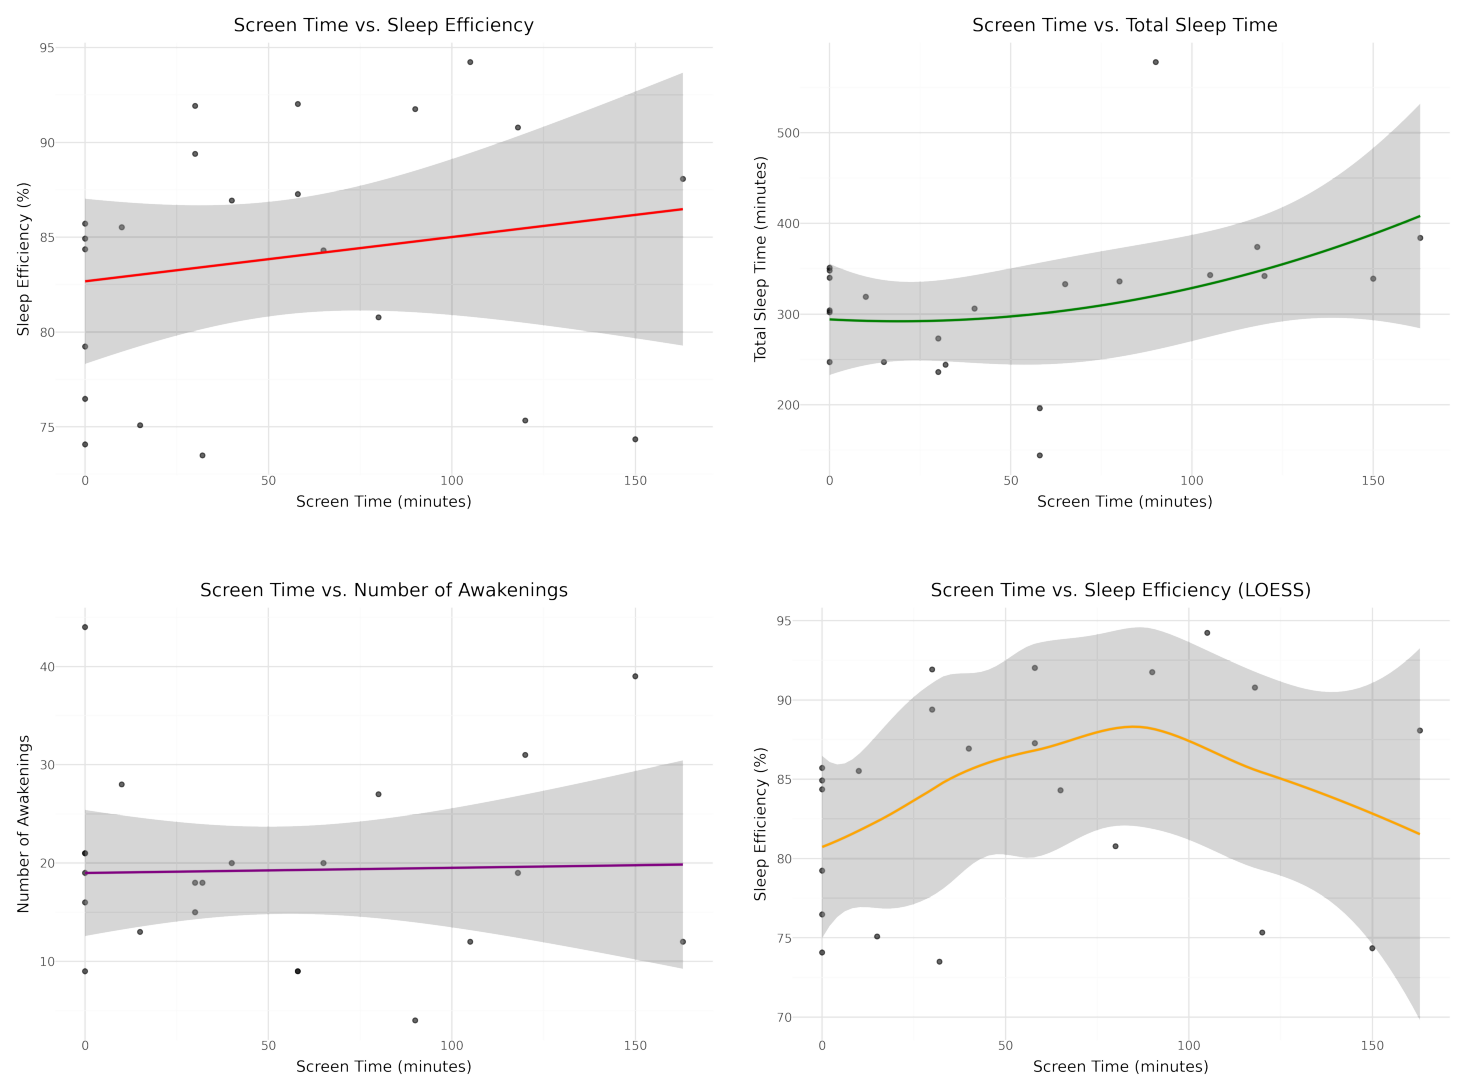

In [70]:
# Initial Data Visualization
# Single scatter plot with linear regression line
(ggplot(daily_metrics_df, aes(x='screen_time_minutes', y='sleep_Efficiency'))
 + geom_point(alpha=0.7, size=3)
 + geom_smooth(method='lm', color='red', se=True)
 + labs(title='Relationship Between Screen Time and Sleep Efficiency',
        x='Screen Time (minutes)',
        y='Sleep Efficiency (%)')
 + theme_minimal()
 + theme(figure_size=(10, 6),
         plot_title=element_text(size=16),
         axis_title=element_text(size=12))
).save('screen_time_vs_sleep_efficiency.png', dpi=300)

# Multiple plots with different regression types
# 1. Screen Time vs Sleep Efficiency (linear)
p1 = (ggplot(daily_metrics_df, aes(x='screen_time_minutes', y='sleep_Efficiency'))
      + geom_point(alpha=0.6)
      + geom_smooth(method='lm', color='red')
      + labs(title='Screen Time vs. Sleep Efficiency',
             x='Screen Time (minutes)',
             y='Sleep Efficiency (%)')
      + theme_minimal())

# 2. Screen Time vs Total Sleep Time (polynomial) - CORRECTED
p2 = (ggplot(daily_metrics_df, aes(x='screen_time_minutes', y='sleep_Total Sleep Time (TST)'))
      + geom_point(alpha=0.6)
      + stat_smooth(method='lm', formula='y ~ x + I(x**2)', color='green')  # Correct polynomial formula
      + labs(title='Screen Time vs. Total Sleep Time',
             x='Screen Time (minutes)',
             y='Total Sleep Time (minutes)')
      + theme_minimal())

# 3. Screen Time vs Number of Awakenings (linear)
p3 = (ggplot(daily_metrics_df, aes(x='screen_time_minutes', y='sleep_Number of Awakenings'))
      + geom_point(alpha=0.6)
      + geom_smooth(method='lm', color='purple')
      + labs(title='Screen Time vs. Number of Awakenings',
             x='Screen Time (minutes)',
             y='Number of Awakenings')
      + theme_minimal())

# 4. Screen Time vs Sleep Efficiency (LOESS/LOWESS)
p4 = (ggplot(daily_metrics_df, aes(x='screen_time_minutes', y='sleep_Efficiency'))
      + geom_point(alpha=0.6)
      + geom_smooth(method='loess', color='orange')
      + labs(title='Screen Time vs. Sleep Efficiency (LOESS)',
             x='Screen Time (minutes)',
             y='Sleep Efficiency (%)')
      + theme_minimal())

# Save individual plots
p1.save('screen_efficiency_linear.png', dpi=300, width=7, height=5)
p2.save('screen_tst_poly.png', dpi=300, width=7, height=5)
p3.save('screen_awakenings_linear.png', dpi=300, width=7, height=5)
p4.save('screen_efficiency_loess.png', dpi=300, width=7, height=5)

# Create a figure with 2x2 subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 12))

# Load saved images and display them in the grid
axs[0, 0].imshow(imread('screen_efficiency_linear.png'))
axs[0, 0].axis('off')

axs[0, 1].imshow(imread('screen_tst_poly.png'))
axs[0, 1].axis('off')

axs[1, 0].imshow(imread('screen_awakenings_linear.png'))
axs[1, 0].axis('off')

axs[1, 1].imshow(imread('screen_efficiency_loess.png'))
axs[1, 1].axis('off')

plt.tight_layout()
plt.savefig('combined_plots.png', dpi=300, bbox_inches='tight')
plt.show()

Removing 'efficiency' from features as it's too similar to the target variable...
Original features: ['Total Sleep Time (TST)', 'Number of Awakenings', 'efficiency', 'screen_time_minutes']
Cleaned features: ['Total Sleep Time (TST)', 'Number of Awakenings', 'screen_time_minutes']
training set: 16 samples
testing set: 6 samples
numeric features: ['Total Sleep Time (TST)', 'Number of Awakenings', 'screen_time_minutes']
categorical features: []

revised linear regression results:
train rmse: 4.6936
test rmse: 7.3488
train mae: 3.8568
test mae: 7.0818
train r²: 0.4950
test r²: -1.7497

feature importance (linear regression coefficients):
                  Feature  Coefficient
0  Total Sleep Time (TST)     0.029151
2     screen_time_minutes    -0.000219
1    Number of Awakenings    -0.350969

Cross-validation R² scores: [ -1.42437193   0.14599337 -12.65647508   0.01593748   0.4673454 ]
Mean R² from cross-validation: -2.6903
Standard deviation of R² scores: 5.0253


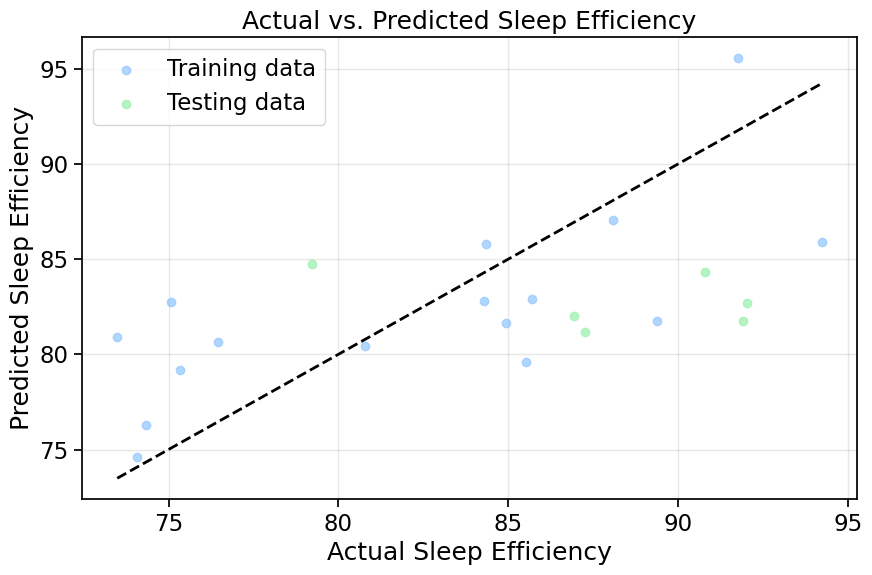

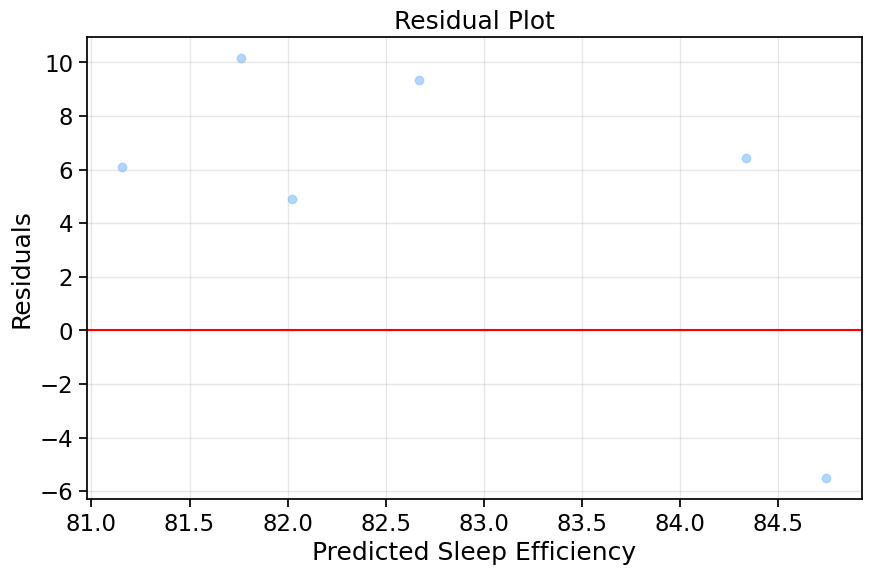


Random Forest results:
train rmse: 2.4297
test rmse: 8.1993
train r²: 0.8647
test r²: -2.4230

Random Forest Feature Importance:
                  Feature  Importance
0  Total Sleep Time (TST)    0.486401
1    Number of Awakenings    0.383530
2     screen_time_minutes    0.130069

Random Forest Cross-validation R² scores: [-2.35731851  0.04975534 -3.7399757   0.40945525 -0.36115591]
RF Mean R² from cross-validation: -1.1998
RF Standard deviation of R² scores: 1.5904


In [71]:
# Linear Regression Model
# First, ensure we remove the efficiency column from our features
print("Removing 'efficiency' from features as it's too similar to the target variable...")

# Check our columns to ensure we're working with the right data
print(f"Original features: {X.columns.tolist()}")

# Create feature set without the efficiency column
X_cleaned = X.drop('efficiency', axis=1) if 'efficiency' in X.columns else X
print(f"Cleaned features: {X_cleaned.columns.tolist()}")

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_cleaned, y, test_size=0.25, random_state=42)
print(f"training set: {len(X_train)} samples")
print(f"testing set: {len(X_test)} samples")

# Print feature types
numeric_features = X_cleaned.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_cleaned.select_dtypes(include=['object', 'category']).columns.tolist()
print(f"numeric features: {numeric_features}")
print(f"categorical features: {categorical_features}")

# Create and train linear regression model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Make predictions
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

# Calculate metrics
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Display results
print("\nrevised linear regression results:")
print(f"train rmse: {train_rmse:.4f}")
print(f"test rmse: {test_rmse:.4f}")
print(f"train mae: {train_mae:.4f}")
print(f"test mae: {test_mae:.4f}")
print(f"train r²: {train_r2:.4f}")
print(f"test r²: {test_r2:.4f}")

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': X_cleaned.columns,
    'Coefficient': lr.coef_
})
print("\nfeature importance (linear regression coefficients):")
print(feature_importance.sort_values('Coefficient', ascending=False))

# Perform cross-validation for more reliable performance assessment
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(lr, X_cleaned, y, cv=kf, scoring='r2')
print("\nCross-validation R² scores:", cv_scores)
print(f"Mean R² from cross-validation: {cv_scores.mean():.4f}")
print(f"Standard deviation of R² scores: {cv_scores.std():.4f}")

# Visualize actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_train, y_train_pred, alpha=0.7, label='Training data')
plt.scatter(y_test, y_test_pred, alpha=0.7, label='Testing data')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Actual Sleep Efficiency')
plt.ylabel('Predicted Sleep Efficiency')
plt.title('Actual vs. Predicted Sleep Efficiency')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('actual_vs_predicted.png', dpi=300, bbox_inches='tight')
plt.show()

# Visualize residuals
residuals = y_test - y_test_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_test_pred, residuals, alpha=0.7)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Predicted Sleep Efficiency')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.grid(True, alpha=0.3)
plt.savefig('residuals_plot.png', dpi=300, bbox_inches='tight')
plt.show()

# Try a more complex model - Random Forest
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Make predictions with Random Forest
rf_y_train_pred = rf.predict(X_train)
rf_y_test_pred = rf.predict(X_test)

# Calculate RF metrics
rf_train_r2 = r2_score(y_train, rf_y_train_pred)
rf_test_r2 = r2_score(y_test, rf_y_test_pred)
rf_train_rmse = np.sqrt(mean_squared_error(y_train, rf_y_train_pred))
rf_test_rmse = np.sqrt(mean_squared_error(y_test, rf_y_test_pred))

print("\nRandom Forest results:")
print(f"train rmse: {rf_train_rmse:.4f}")
print(f"test rmse: {rf_test_rmse:.4f}")
print(f"train r²: {rf_train_r2:.4f}")
print(f"test r²: {rf_test_r2:.4f}")

# Random Forest feature importance
rf_feature_importance = pd.DataFrame({
    'Feature': X_cleaned.columns,
    'Importance': rf.feature_importances_
})
print("\nRandom Forest Feature Importance:")
print(rf_feature_importance.sort_values('Importance', ascending=False))

# Cross-validation for Random Forest
rf_cv_scores = cross_val_score(rf, X_cleaned, y, cv=kf, scoring='r2')
print("\nRandom Forest Cross-validation R² scores:", rf_cv_scores)
print(f"RF Mean R² from cross-validation: {rf_cv_scores.mean():.4f}")
print(f"RF Standard deviation of R² scores: {rf_cv_scores.std():.4f}")

In [72]:
# Remove potentially duplicated efficiency feature
X_no_efficiency = X.drop('efficiency', axis=1)

# Implement cross-validation
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression

kf = KFold(n_splits=5, shuffle=True, random_state=42)
model = LinearRegression()

cv_scores = cross_val_score(model, X_no_efficiency, y, cv=kf, scoring='r2')
print(f"Cross-validation R² scores: {cv_scores}")
print(f"Mean R² from cross-validation: {cv_scores.mean():.4f}")

# Train model on entire dataset without efficiency feature to get coefficient importance
model.fit(X_no_efficiency, y)
feature_importance = pd.DataFrame({
    'Feature': X_no_efficiency.columns,
    'Coefficient': model.coef_
})
print("\nFeature importance without efficiency feature:")
print(feature_importance.sort_values('Coefficient', ascending=False))

Cross-validation R² scores: [ -1.42437193   0.14599337 -12.65647508   0.01593748   0.4673454 ]
Mean R² from cross-validation: -2.6903

Feature importance without efficiency feature:
                  Feature  Coefficient
2     screen_time_minutes     0.020361
0  Total Sleep Time (TST)     0.009050
1    Number of Awakenings    -0.421352


Creating model with interaction terms...

Interaction Model Results:
train rmse: 4.2207
test rmse: 6.7640
train r²: 0.5916
test r²: -1.3295

Feature importance with interaction terms:
                  Feature  Coefficient
2     screen_time_minutes     0.037105
3        TST_x_Awakenings     0.004557
4     Screen_x_Awakenings    -0.001956
0  Total Sleep Time (TST)    -0.015347
1    Number of Awakenings    -1.844826

Interaction Model Cross-validation R² scores: [ -1.39093231  -0.5814699  -24.54484807   0.19902574  -0.39503645]
Mean R² from cross-validation: -5.3427
Standard deviation of R² scores: 9.6146

Creating model with quadratic terms...
Polynomial features created: ['Total Sleep Time (TST)', 'Number of Awakenings', 'screen_time_minutes', 'Total Sleep Time (TST)^2', 'Total Sleep Time (TST) Number of Awakenings', 'Total Sleep Time (TST) screen_time_minutes', 'Number of Awakenings^2', 'Number of Awakenings screen_time_minutes', 'screen_time_minutes^2']

Quadratic Model Results:
trai

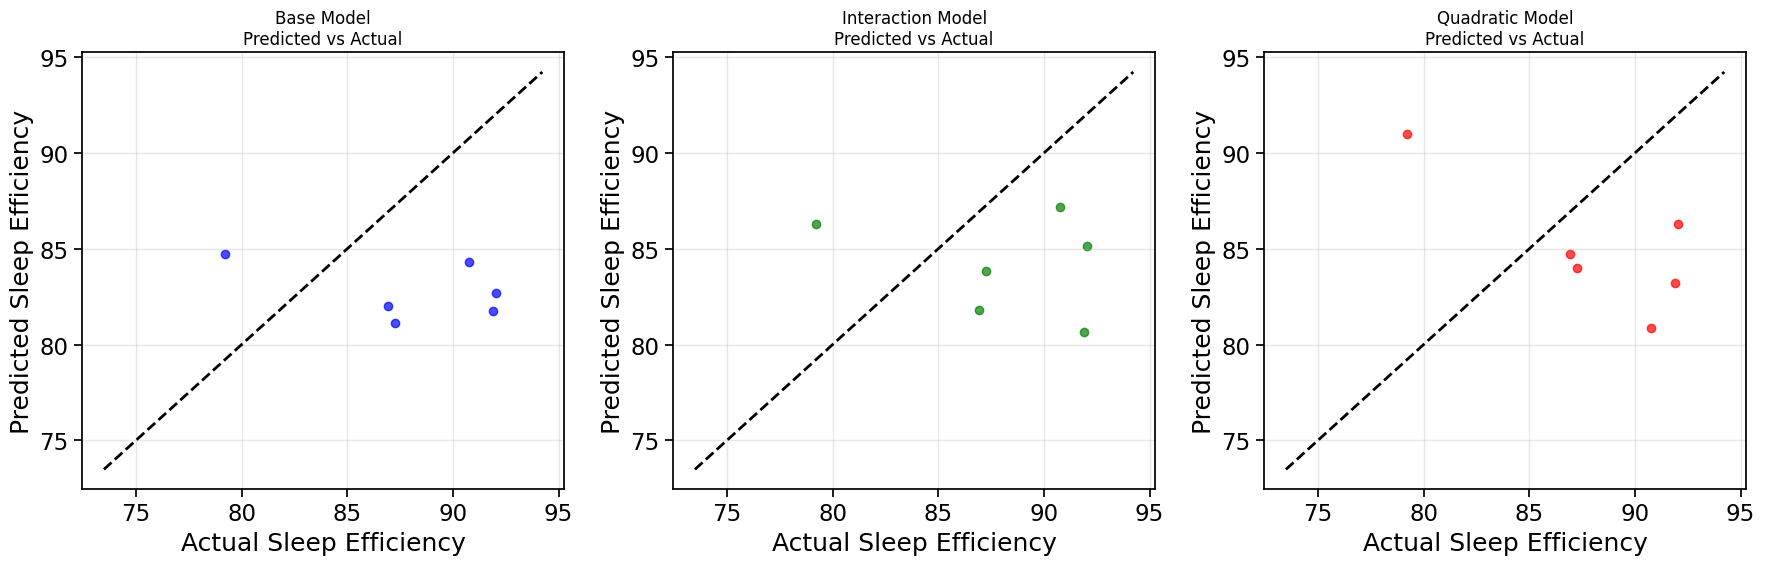

In [73]:
# Enhanced Models
# Model 1: Interaction Terms
# Keep the original cleaned features
X_cleaned_original = X_cleaned.copy()

# Create interaction terms between features
print("Creating model with interaction terms...")

# First, let's create an interaction term between Total Sleep Time and Number of Awakenings
X_cleaned['TST_x_Awakenings'] = X_cleaned['Total Sleep Time (TST)'] * X_cleaned['Number of Awakenings']

# Create interaction between screen time and awakenings
X_cleaned['Screen_x_Awakenings'] = X_cleaned['screen_time_minutes'] * X_cleaned['Number of Awakenings']

# Split data
X_train_int, X_test_int, y_train, y_test = train_test_split(X_cleaned, y, test_size=0.25, random_state=42)

# Train interaction model
lr_interaction = LinearRegression()
lr_interaction.fit(X_train_int, y_train)

# Evaluate
y_train_pred_int = lr_interaction.predict(X_train_int)
y_test_pred_int = lr_interaction.predict(X_test_int)

# Calculate metrics
train_rmse_int = np.sqrt(mean_squared_error(y_train, y_train_pred_int))
test_rmse_int = np.sqrt(mean_squared_error(y_test, y_test_pred_int))
train_r2_int = r2_score(y_train, y_train_pred_int)
test_r2_int = r2_score(y_test, y_test_pred_int)

print("\nInteraction Model Results:")
print(f"train rmse: {train_rmse_int:.4f}")
print(f"test rmse: {test_rmse_int:.4f}")
print(f"train r²: {train_r2_int:.4f}")
print(f"test r²: {test_r2_int:.4f}")

# Feature importance
feature_importance_int = pd.DataFrame({
    'Feature': X_cleaned.columns,
    'Coefficient': lr_interaction.coef_
})
print("\nFeature importance with interaction terms:")
print(feature_importance_int.sort_values('Coefficient', ascending=False))

# Cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores_int = cross_val_score(lr_interaction, X_cleaned, y, cv=kf, scoring='r2')
print("\nInteraction Model Cross-validation R² scores:", cv_scores_int)
print(f"Mean R² from cross-validation: {cv_scores_int.mean():.4f}")
print(f"Standard deviation of R² scores: {cv_scores_int.std():.4f}")

# Model 2: Quadratic Terms
# Reset to original features before adding quadratic terms
X_cleaned = X_cleaned_original.copy()

print("\nCreating model with quadratic terms...")

# Create polynomial features (includes original features, squared terms, and interaction terms)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_cleaned)

# Get feature names
feature_names = poly.get_feature_names_out(X_cleaned.columns)
print(f"Polynomial features created: {feature_names.tolist()}")

# Split data
X_train_poly, X_test_poly, y_train, y_test = train_test_split(X_poly, y, test_size=0.25, random_state=42)

# Train quadratic model
lr_quadratic = LinearRegression()
lr_quadratic.fit(X_train_poly, y_train)

# Evaluate
y_train_pred_poly = lr_quadratic.predict(X_train_poly)
y_test_pred_poly = lr_quadratic.predict(X_test_poly)

# Calculate metrics
train_rmse_poly = np.sqrt(mean_squared_error(y_train, y_train_pred_poly))
test_rmse_poly = np.sqrt(mean_squared_error(y_test, y_test_pred_poly))
train_r2_poly = r2_score(y_train, y_train_pred_poly)
test_r2_poly = r2_score(y_test, y_test_pred_poly)

print("\nQuadratic Model Results:")
print(f"train rmse: {train_rmse_poly:.4f}")
print(f"test rmse: {test_rmse_poly:.4f}")
print(f"train r²: {train_r2_poly:.4f}")
print(f"test r²: {test_r2_poly:.4f}")

# Feature importance
feature_importance_poly = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': lr_quadratic.coef_
})
print("\nFeature importance with polynomial terms (top 10):")
print(feature_importance_poly.sort_values('Coefficient', ascending=False).head(10))
print("\nFeature importance with polynomial terms (bottom 10):")
print(feature_importance_poly.sort_values('Coefficient', ascending=True).head(10))

# Cross-validation
cv_scores_poly = cross_val_score(lr_quadratic, X_poly, y, cv=kf, scoring='r2')
print("\nQuadratic Model Cross-validation R² scores:", cv_scores_poly)
print(f"Mean R² from cross-validation: {cv_scores_poly.mean():.4f}")
print(f"Standard deviation of R² scores: {cv_scores_poly.std():.4f}")

# Compare model performance 
print("\n=== Model Comparison ===")
print("                    Base Model    Interaction Model    Quadratic Model")
print(f"Training R²:        {train_r2:.4f}           {train_r2_int:.4f}             {train_r2_poly:.4f}")  
print(f"Testing R²:         {test_r2:.4f}           {test_r2_int:.4f}             {test_r2_poly:.4f}")
print(f"CV Mean R²:        {cv_scores.mean():.4f}           {cv_scores_int.mean():.4f}             {cv_scores_poly.mean():.4f}")
print(f"CV Std Dev:        {cv_scores.std():.4f}           {cv_scores_int.std():.4f}             {cv_scores_poly.std():.4f}")

# Create visualization of predicted vs actual values for all models
plt.figure(figsize=(18, 6))

# Base model
plt.subplot(1, 3, 1)
plt.scatter(y_test, y_test_pred, alpha=0.7, color='blue')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.title('Base Model\nPredicted vs Actual', fontsize=12)
plt.xlabel('Actual Sleep Efficiency')
plt.ylabel('Predicted Sleep Efficiency')
plt.grid(True, alpha=0.3)

# Interaction model
plt.subplot(1, 3, 2)
plt.scatter(y_test, y_test_pred_int, alpha=0.7, color='green')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.title('Interaction Model\nPredicted vs Actual', fontsize=12)
plt.xlabel('Actual Sleep Efficiency')
plt.ylabel('Predicted Sleep Efficiency')
plt.grid(True, alpha=0.3)

# Quadratic model
plt.subplot(1, 3, 3)
plt.scatter(y_test, y_test_pred_poly, alpha=0.7, color='red')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.title('Quadratic Model\nPredicted vs Actual', fontsize=12)
plt.xlabel('Actual Sleep Efficiency')
plt.ylabel('Predicted Sleep Efficiency')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [74]:
# Ridge Regression
# Ridge regression with cross-validation to find optimal alpha
param_grid = {'alpha': np.logspace(-4, 4, 20)}
ridge_cv = GridSearchCV(Ridge(), param_grid, cv=5, scoring='r2')
ridge_cv.fit(X_poly, y)  # Use polynomial features for Ridge

best_alpha = ridge_cv.best_params_['alpha']
print(f"\nBest alpha for Ridge regression: {best_alpha:.6f}")

# Train Ridge with best alpha
ridge_best = Ridge(alpha=best_alpha)
ridge_best.fit(X_train_poly, y_train)

# Evaluate
y_train_pred_ridge = ridge_best.predict(X_train_poly)
y_test_pred_ridge = ridge_best.predict(X_test_poly)

# Calculate metrics
train_rmse_ridge = np.sqrt(mean_squared_error(y_train, y_train_pred_ridge))
test_rmse_ridge = np.sqrt(mean_squared_error(y_test, y_test_pred_ridge))
train_r2_ridge = r2_score(y_train, y_train_pred_ridge)
test_r2_ridge = r2_score(y_test, y_test_pred_ridge)

print("\nRegularized Quadratic Model Results:")
print(f"train rmse: {train_rmse_ridge:.4f}")
print(f"test rmse: {test_rmse_ridge:.4f}")
print(f"train r²: {train_r2_ridge:.4f}")
print(f"test r²: {test_r2_ridge:.4f}")

# Cross-validation
cv_scores_ridge = cross_val_score(ridge_best, X_poly, y, cv=kf, scoring='r2')
print("\nRegularized Model Cross-validation R² scores:", cv_scores_ridge)
print(f"Mean R² from cross-validation: {cv_scores_ridge.mean():.4f}")
print(f"Standard deviation of R² scores: {cv_scores_ridge.std():.4f}")


Best alpha for Ridge regression: 10000.000000

Regularized Quadratic Model Results:
train rmse: 4.2504
test rmse: 8.4163
train r²: 0.5859
test r²: -2.6065

Regularized Model Cross-validation R² scores: [ -2.89797375   0.12446302 -50.21833473  -2.16153591   0.5218116 ]
Mean R² from cross-validation: -10.9263
Standard deviation of R² scores: 19.6892


In [75]:
# Hyperparameter Tuning
print("Hyperparameter Tuning for Small Sample Size Sleep Efficiency Analysis")
print("Sample size: 22 observations (16 training, 6 testing)")

# Use the original cleaned features (without efficiency)
X_final = X_cleaned.copy()

# Create interaction term BEFORE splitting the data
X_final['Awakenings_x_Screen'] = X_final['Number of Awakenings'] * X_final['screen_time_minutes']

# Split data consistently with previous analysis
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.25, random_state=42)

# 1. Ridge Regression with carefully selected alpha range
print("\n1. Ridge Regression Tuning")
ridge_params = {'alpha': [0.01, 0.1, 1, 10, 100, 1000]}
ridge_cv = GridSearchCV(
    Ridge(), 
    ridge_params, 
    cv=5, 
    scoring='neg_mean_squared_error',
    return_train_score=True
)
ridge_cv.fit(X_final, y)

print(f"Best Ridge alpha: {ridge_cv.best_params_['alpha']}")
print(f"Best Ridge CV RMSE: {np.sqrt(-ridge_cv.best_score_):.4f}")

# 2. Lasso Regression (promotes sparsity, good for small samples)
print("\n2. Lasso Regression Tuning")
lasso_params = {'alpha': [0.001, 0.01, 0.1, 0.5, 1, 10]}
lasso_cv = GridSearchCV(
    Lasso(max_iter=10000), 
    lasso_params, 
    cv=5, 
    scoring='neg_mean_squared_error',
    return_train_score=True
)
lasso_cv.fit(X_final, y)

print(f"Best Lasso alpha: {lasso_cv.best_params_['alpha']}")
print(f"Best Lasso CV RMSE: {np.sqrt(-lasso_cv.best_score_):.4f}")

# Train best models on full training data and evaluate on test set
best_ridge = Ridge(alpha=ridge_cv.best_params_['alpha'])
best_ridge.fit(X_train, y_train)
ridge_train_pred = best_ridge.predict(X_train)
ridge_test_pred = best_ridge.predict(X_test)

best_lasso = Lasso(alpha=lasso_cv.best_params_['alpha'], max_iter=10000)
best_lasso.fit(X_train, y_train)
lasso_train_pred = best_lasso.predict(X_train)
lasso_test_pred = best_lasso.predict(X_test)

# Calculate metrics
print("\n=== Final Model Comparison ===")
print("                           Ridge           Lasso")
print(f"Training RMSE:           {np.sqrt(mean_squared_error(y_train, ridge_train_pred)):.4f}         {np.sqrt(mean_squared_error(y_train, lasso_train_pred)):.4f}")
print(f"Test RMSE:               {np.sqrt(mean_squared_error(y_test, ridge_test_pred)):.4f}         {np.sqrt(mean_squared_error(y_test, lasso_test_pred)):.4f}")
print(f"Training R²:             {r2_score(y_train, ridge_train_pred):.4f}         {r2_score(y_train, lasso_train_pred):.4f}")
print(f"Test R²:                 {r2_score(y_test, ridge_test_pred):.4f}         {r2_score(y_test, lasso_test_pred):.4f}")

# FIX: Make sure we're using the right feature names (from fitted model)
# Verify lengths before creating DataFrame
print(f"\nNumber of features in X_final: {len(X_final.columns)}")
print(f"Length of Lasso coefficients: {len(best_lasso.coef_)}")

# Correct way to create the DataFrame
feature_names = X_final.columns
lasso_coef = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': best_lasso.coef_
})
print("\nLasso coefficients (features with non-zero coefficients are selected):")
print(lasso_coef.sort_values('Coefficient', ascending=False))

# Feature stability analysis using bootstrap
from sklearn.utils import resample

print("\nFeature Stability Analysis (Bootstrap, 100 samples)")
n_bootstraps = 100
bootstrap_coefs = {feature: [] for feature in X_final.columns}

for i in range(n_bootstraps):
    # Bootstrap sample
    X_boot, y_boot = resample(X_final, y, random_state=i)
    
    # Fit model
    model = Lasso(alpha=lasso_cv.best_params_['alpha'], max_iter=10000)
    model.fit(X_boot, y_boot)
    
    # Store coefficients
    for j, feature in enumerate(X_final.columns):
        bootstrap_coefs[feature].append(model.coef_[j])

# Calculate bootstrap statistics
bootstrap_stats = []
for feature in X_final.columns:
    coefs = bootstrap_coefs[feature]
    bootstrap_stats.append({
        'Feature': feature,
        'Mean Coef': np.mean(coefs),
        'Std Dev': np.std(coefs),
        'CI Lower': np.percentile(coefs, 2.5),
        'CI Upper': np.percentile(coefs, 97.5),
        'Selection %': np.mean([c != 0 for c in coefs]) * 100
    })

bootstrap_df = pd.DataFrame(bootstrap_stats)
print(bootstrap_df.sort_values('Selection %', ascending=False))

Hyperparameter Tuning for Small Sample Size Sleep Efficiency Analysis
Sample size: 22 observations (16 training, 6 testing)

1. Ridge Regression Tuning
Best Ridge alpha: 1000
Best Ridge CV RMSE: 5.9292

2. Lasso Regression Tuning
Best Lasso alpha: 10
Best Lasso CV RMSE: 5.9109

=== Final Model Comparison ===
                           Ridge           Lasso
Training RMSE:           4.5739         4.6506
Test RMSE:               6.8535         6.9303
Training R²:             0.5204         0.5042
Test R²:                 -1.3915         -1.4454

Number of features in X_final: 4
Length of Lasso coefficients: 4

Lasso coefficients (features with non-zero coefficients are selected):
                  Feature  Coefficient
2     screen_time_minutes     0.077493
0  Total Sleep Time (TST)     0.018423
3     Awakenings_x_Screen    -0.003289
1    Number of Awakenings    -0.060062

Feature Stability Analysis (Bootstrap, 100 samples)
                  Feature  Mean Coef   Std Dev  CI Lower  CI Uppe

In [76]:
# Confounding Analysis w/ Statsmodels
# create a clean dataset for statsmodels analysis
sm_data = X.copy()
sm_data[target_col_short] = y

# select key variables for analysis
key_vars = []

# find heart rate variable
hr_vars = [col for col in sm_data.columns if col in ['mean_rr', 'rmssd', 'sdnn']]
if hr_vars:
    key_vars.extend(hr_vars[:1])  # add first heart rate variable

# add stress index if available
if 'stress_index' in sm_data.columns:
    key_vars.append('stress_index')

# add screen time if available
if 'screen_time_minutes' in sm_data.columns:
    key_vars.append('screen_time_minutes')

print(f"\nselected key variables for confounding analysis: {key_vars}")

# univariate models (one predictor at a time)
univariate_results = {}
for var in key_vars:
    formula = f"{target_col_short} ~ {var}"
    try:
        model = smf.ols(formula=formula, data=sm_data).fit()
        univariate_results[var] = {
            'coef': model.params[var],
            'p_value': model.pvalues[var],
            'r_squared': model.rsquared
        }
    except Exception as e:
        print(f"error in univariate model for {var}: {str(e)}")

# multivariate model (all predictors)
if len(key_vars) > 1:
    formula = f"{target_col_short} ~ " + " + ".join(key_vars)
    try:
        multi_model = smf.ols(formula=formula, data=sm_data).fit()
        
        # calculate VIF for multicollinearity
        vif_data = pd.DataFrame()
        sm_data_with_const = sm.add_constant(sm_data[key_vars])
        vif_data['Feature'] = sm_data_with_const.columns
        vif_data['VIF'] = [variance_inflation_factor(sm_data_with_const.values, i) 
                          for i in range(sm_data_with_const.shape[1])]
        
        print("\nvariance inflation factors (multicollinearity check):")
        display(vif_data)
        
        # create confounding comparison table
        confounding_table = pd.DataFrame(index=key_vars, 
                                        columns=['Univariate Coef', 'Univariate p-value', 
                                                'Multivariate Coef', 'Multivariate p-value',
                                                'Coefficient Change %'])
        
        for var in key_vars:
            if var in univariate_results:
                uni_coef = univariate_results[var]['coef']
                multi_coef = multi_model.params[var]
                
                confounding_table.loc[var, 'Univariate Coef'] = uni_coef
                confounding_table.loc[var, 'Univariate p-value'] = univariate_results[var]['p_value']
                confounding_table.loc[var, 'Multivariate Coef'] = multi_coef
                confounding_table.loc[var, 'Multivariate p-value'] = multi_model.pvalues[var]
                
                # calculate coefficient change percentage
                if uni_coef != 0:
                    coef_change = ((multi_coef - uni_coef) / abs(uni_coef)) * 100
                    confounding_table.loc[var, 'Coefficient Change %'] = coef_change
        
        print("\nconfounding analysis results:")
        display(confounding_table)
        
        print("\nmultivariate model summary:")
        print(multi_model.summary())
        
        # interpret confounding relationships
        print("\ninterpretation of potential confounding:")
        for var in key_vars:
            if var in confounding_table.index:
                coef_change = confounding_table.loc[var, 'Coefficient Change %']
                if pd.notnull(coef_change) and abs(coef_change) > 10:
                    print(f"- {var}: Coefficient changed by {coef_change:.1f}% when controlling for other variables, " 
                          f"suggesting potential confounding relationships")
                elif pd.notnull(coef_change):
                    print(f"- {var}: Coefficient changed by only {coef_change:.1f}% when controlling for other variables, " 
                          f"suggesting minimal confounding effects")
    except Exception as e:
        print(f"error in multivariate model: {str(e)}")


selected key variables for confounding analysis: ['screen_time_minutes']


Confounding Analysis for Sleep Efficiency Study
Sample Size: 22

Original columns in analysis DataFrame:
['user_id', 'date', 'sleep_Efficiency', 'sleep_Total Sleep Time (TST)', 'sleep_Number of Awakenings', 'sleep_sleep_efficiency', 'screen_time_minutes']

Clean column names for analysis:
['user_id', 'date', 'sleep_Efficiency', 'screen_time_minutes', 'sleep_total_sleep_time', 'sleep_number_awakenings', 'sleep_efficiency']

1. Checking for multicollinearity (VIF > 5 indicates potential issues)
                   Feature        VIF
0                    const  18.936717
1      screen_time_minutes   1.144553
2   sleep_total_sleep_time   1.146309
3  sleep_number_awakenings   1.002457

2. Assessing confounding on screen time relationship with sleep efficiency

Model 1 (Unadjusted): sleep_efficiency ~ screen_time_minutes
Screen Time Coefficient: 0.023347, p-value: 0.4218

Model 2 (Adjusted for Total Sleep Time): sleep_efficiency ~ screen_time_minutes + sleep_total_sleep_time
Screen Time Coeff

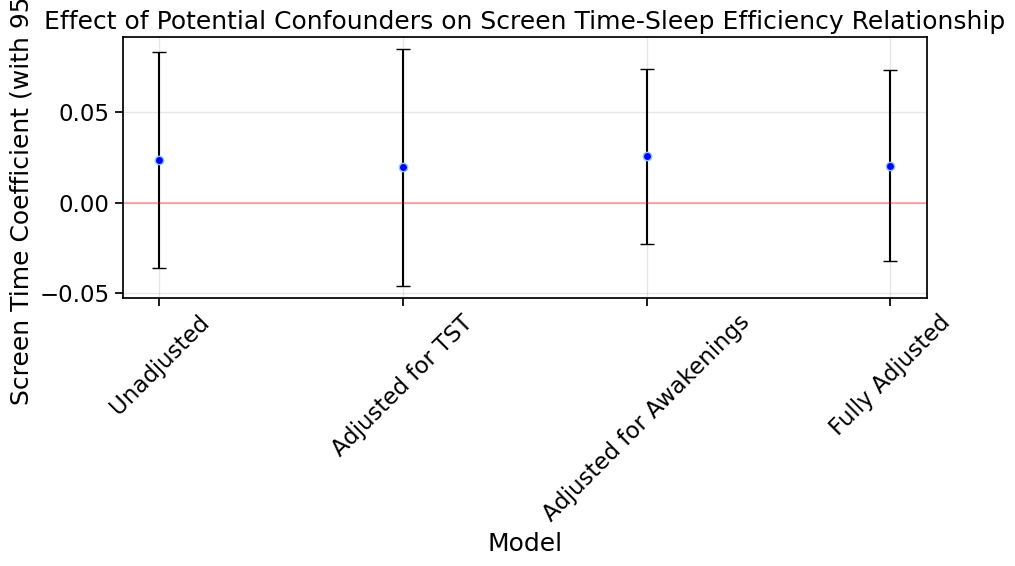


5. Full summary for fully adjusted model:
                            OLS Regression Results                            
Dep. Variable:       sleep_efficiency   R-squared:                       0.411
Model:                            OLS   Adj. R-squared:                  0.313
Method:                 Least Squares   F-statistic:                     4.188
Date:                Sat, 07 Jun 2025   Prob (F-statistic):             0.0206
Time:                        13:46:49   Log-Likelihood:                -66.876
No. Observations:                  22   AIC:                             141.8
Df Residuals:                      18   BIC:                             146.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------

In [77]:
# Confounding Analysis for Sleep Efficiency Study
print("Confounding Analysis for Sleep Efficiency Study")
print("Sample Size:", len(daily_metrics_df))

# Create a copy for analysis
analysis_df = daily_metrics_df.copy()

# Print original column names
print("\nOriginal columns in analysis DataFrame:")
print(analysis_df.columns.tolist())

# Create a clean version of the DataFrame with renamed columns
clean_df = analysis_df.copy()

# Dictionary to map old column names to new ones without spaces or special characters
column_mapping = {
    'sleep_Total Sleep Time (TST)': 'sleep_total_sleep_time',
    'sleep_Number of Awakenings': 'sleep_number_awakenings',
    'screen_time_minutes': 'screen_time_minutes',  # No change needed
    'sleep_sleep_efficiency': 'sleep_efficiency'
}

# Create the clean DataFrame with renamed columns
for old_col, new_col in column_mapping.items():
    if old_col in clean_df.columns:
        clean_df[new_col] = clean_df[old_col]

# Drop the original columns
clean_df = clean_df[[col for col in clean_df.columns if col not in column_mapping.keys() or col == column_mapping.get(col)]]

# Print the clean column names 
print("\nClean column names for analysis:")
print(clean_df.columns.tolist())

# Target variable
target_var = 'sleep_efficiency'

# Predictor variables with clean names
screen_time_col = 'screen_time_minutes'
tst_col = 'sleep_total_sleep_time'
awakenings_col = 'sleep_number_awakenings'

# Check columns exist in clean DataFrame
for col in [screen_time_col, tst_col, awakenings_col, target_var]:
    if col not in clean_df.columns:
        print(f"WARNING: Column '{col}' not found in clean DataFrame!")

# 1. Check for multicollinearity using VIF
print("\n1. Checking for multicollinearity (VIF > 5 indicates potential issues)")
predictor_cols = [screen_time_col, tst_col, awakenings_col]
predictor_cols = [col for col in predictor_cols if col in clean_df.columns]

X = clean_df[predictor_cols]
X = sm.add_constant(X)

vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

# 2. Series of models to assess confounding
print("\n2. Assessing confounding on screen time relationship with sleep efficiency")

# Unadjusted model (bivariate)
formula1 = f"{target_var} ~ {screen_time_col}"
model1 = smf.ols(formula=formula1, data=clean_df).fit()
print(f"\nModel 1 (Unadjusted): {formula1}")
print(f"Screen Time Coefficient: {model1.params[screen_time_col]:.6f}, p-value: {model1.pvalues[screen_time_col]:.4f}")

# Adjusted for TST
formula2 = f"{target_var} ~ {screen_time_col} + {tst_col}"
model2 = smf.ols(formula=formula2, data=clean_df).fit()
print(f"\nModel 2 (Adjusted for Total Sleep Time): {formula2}")
print(f"Screen Time Coefficient: {model2.params[screen_time_col]:.6f}, p-value: {model2.pvalues[screen_time_col]:.4f}")

# Adjusted for Awakenings
formula3 = f"{target_var} ~ {screen_time_col} + {awakenings_col}"
model3 = smf.ols(formula=formula3, data=clean_df).fit()
print(f"\nModel 3 (Adjusted for Awakenings): {formula3}")
print(f"Screen Time Coefficient: {model3.params[screen_time_col]:.6f}, p-value: {model3.pvalues[screen_time_col]:.4f}")

# Fully adjusted model
formula4 = f"{target_var} ~ {screen_time_col} + {tst_col} + {awakenings_col}"
model4 = smf.ols(formula=formula4, data=clean_df).fit()
print(f"\nModel 4 (Fully Adjusted): {formula4}")
print(f"Screen Time Coefficient: {model4.params[screen_time_col]:.6f}, p-value: {model4.pvalues[screen_time_col]:.4f}")

# 3. Compare coefficients across models
print("\n3. Screen Time Coefficient Comparison Across Models")
models = [model1, model2, model3, model4]
model_names = ["Unadjusted", "Adjusted for TST", "Adjusted for Awakenings", "Fully Adjusted"]
formulas = [formula1, formula2, formula3, formula4]

confound_results = pd.DataFrame({
    'Model': model_names,
    'Formula': formulas,
    'Screen Time Coefficient': [model.params[screen_time_col] for model in models],
    'P-value': [model.pvalues[screen_time_col] for model in models],
    'Model R²': [model.rsquared for model in models],
    '95% CI Lower': [model.conf_int().loc[screen_time_col][0] for model in models],
    '95% CI Upper': [model.conf_int().loc[screen_time_col][1] for model in models]
})

print(confound_results[['Model', 'Screen Time Coefficient', 'P-value', 'Model R²']])

# Calculate percent change in coefficient from unadjusted
baseline = model1.params[screen_time_col]
confound_results['% Change from Unadjusted'] = [(coef - baseline) / baseline * 100 for coef in confound_results['Screen Time Coefficient']]
print("\nPercent change in screen time coefficient when adjusting for confounders:")
print(confound_results[['Model', '% Change from Unadjusted']])

# 4. Visual representation
plt.figure(figsize=(10, 6))
plt.errorbar(x=range(len(confound_results)), 
             y=confound_results['Screen Time Coefficient'],
             yerr=[(confound_results['Screen Time Coefficient'] - confound_results['95% CI Lower']), 
                   (confound_results['95% CI Upper'] - confound_results['Screen Time Coefficient'])],
             fmt='o', capsize=5, ecolor='black', markerfacecolor='blue')

plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.xticks(range(len(confound_results)), confound_results['Model'], rotation=45)
plt.xlabel('Model')
plt.ylabel('Screen Time Coefficient (with 95% CI)')
plt.title('Effect of Potential Confounders on Screen Time-Sleep Efficiency Relationship')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('confounding_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# 5. Display summary for final model
print("\n5. Full summary for fully adjusted model:")
print(model4.summary())

# Test for normality of residuals
from scipy import stats
residuals = model4.resid
stat, p_value = stats.shapiro(residuals)
print(f"\nShapiro-Wilk test for normality of residuals: W={stat:.4f}, p-value={p_value:.4f}")
print(f"Residuals {'appear normal' if p_value > 0.05 else 'do not appear normal'} (alpha=0.05)")

# Key findings
print("\nKey findings from confounding analysis:")
if any(abs(percent) > 10 for percent in confound_results['% Change from Unadjusted'][1:]):
    print("- Evidence of confounding: Screen time coefficient changes by >10% when adjusting for other variables")
    # Identify strongest confounder
    max_change_idx = abs(confound_results['% Change from Unadjusted'][1:]).argmax() + 1
    print(f"- The strongest confounder appears to be in the {confound_results['Model'][max_change_idx]} model")
else:
    print("- Limited evidence of confounding: Screen time coefficient changes by <10% when adjusting")

print(f"- Screen time shows a {'statistically significant' if model4.pvalues[screen_time_col] < 0.05 else 'non-significant'} relationship with sleep efficiency in the fully adjusted model (p={model4.pvalues[screen_time_col]:.4f})")

if model4.rsquared > model1.rsquared * 1.5:
    print(f"- Adding confounders substantially improves model fit (R² increases from {model1.rsquared:.4f} to {model4.rsquared:.4f})")
else:
    print(f"- Adding confounders offers modest improvement in model fit (R² increases from {model1.rsquared:.4f} to {model4.rsquared:.4f})")

print("\nNote: With only 22 observations, these results should be interpreted cautiously.")

Heart Rate and Stress Index Relationship Analysis
Sample Size: 310

Columns in HRV DataFrame:
['timestamp', 'mean_rr', 'sdnn', 'rmssd', 'pnn50']

Descriptive Statistics for HRV Data:
                 timestamp      mean_rr         sdnn        rmssd       pnn50
count                  310   310.000000   310.000000   310.000000  310.000000
mean   2000-01-01 21:57:54   804.482139   223.035974   309.145026   74.023227
min    2000-01-01 09:05:24   394.658744   120.937796   160.633054   47.869674
25%    2000-01-01 15:31:39   734.296250   155.784618   216.111414   70.836463
50%    2000-01-01 21:57:54   766.884826   182.100074   250.655291   73.725374
75%    2000-01-02 04:24:09   915.356078   229.318165   317.954488   77.547141
max    2000-01-02 10:50:24  1048.912683  1733.337500  2330.543983   83.281802
std                    NaN   134.651888   151.878426   210.678960    4.685647

Missing values in each column:
timestamp    0
mean_rr      0
sdnn         0
rmssd        0
pnn50        0
dtype: i

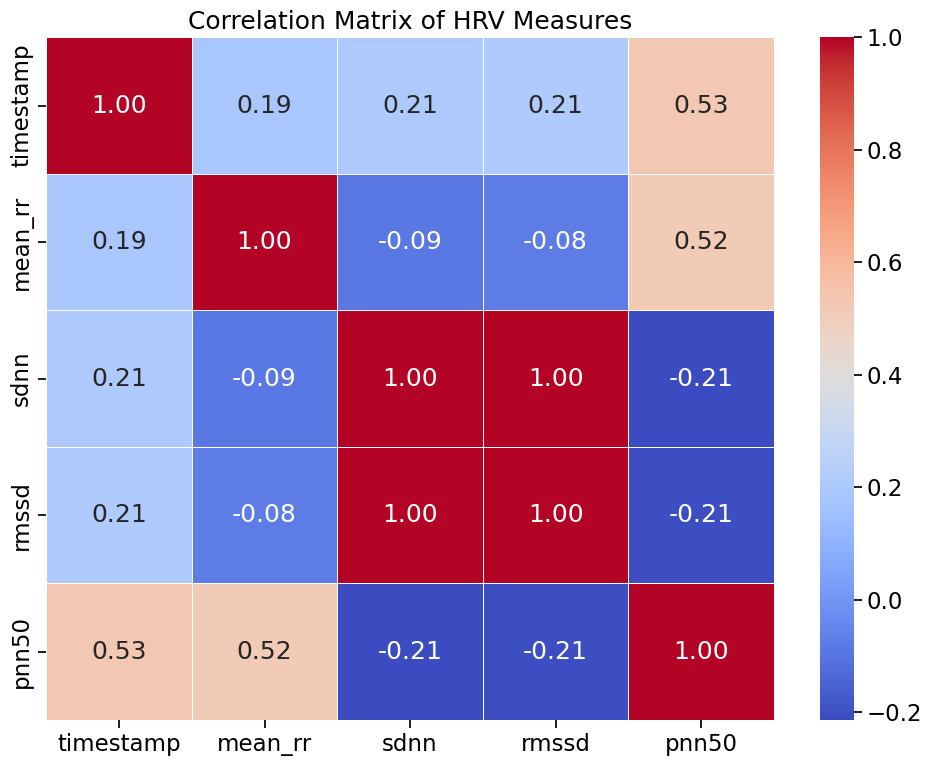


Using rmssd as target variable (stress indicator)
Using mean_rr as primary predictor (heart rate measure)

4. Basic Regression Analysis:
Linear Regression Results:
Training RMSE: 216.4887
Test RMSE: 188.0757
Training R²: 0.0048
Test R²: 0.0095
Coefficient: -0.111979


c:\Users\mihir\OneDrive\Desktop\EPI233\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names


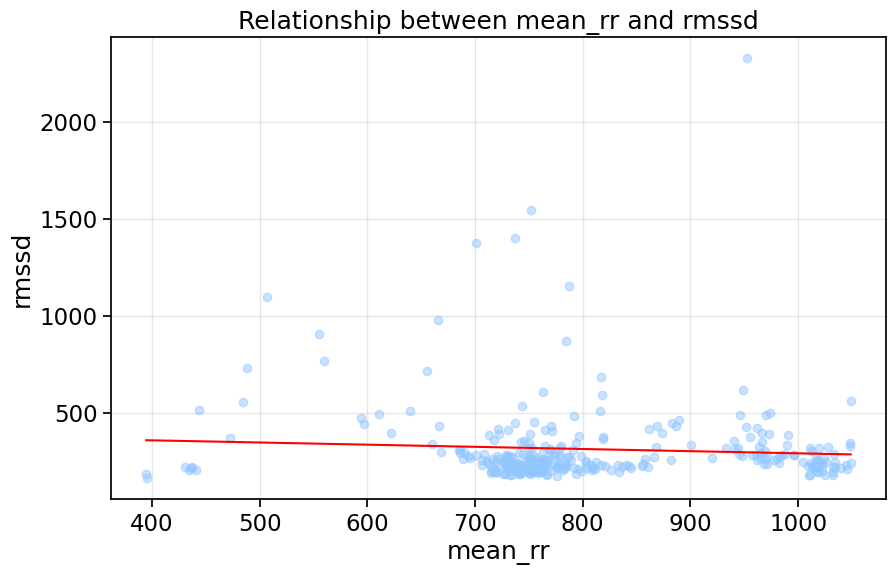


5. Detailed Statistical Analysis:
                            OLS Regression Results                            
Dep. Variable:                  rmssd   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.920
Date:                Sat, 07 Jun 2025   Prob (F-statistic):              0.167
Time:                        13:46:50   Log-Likelihood:                -2097.0
No. Observations:                 310   AIC:                             4198.
Df Residuals:                     308   BIC:                             4205.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        408.

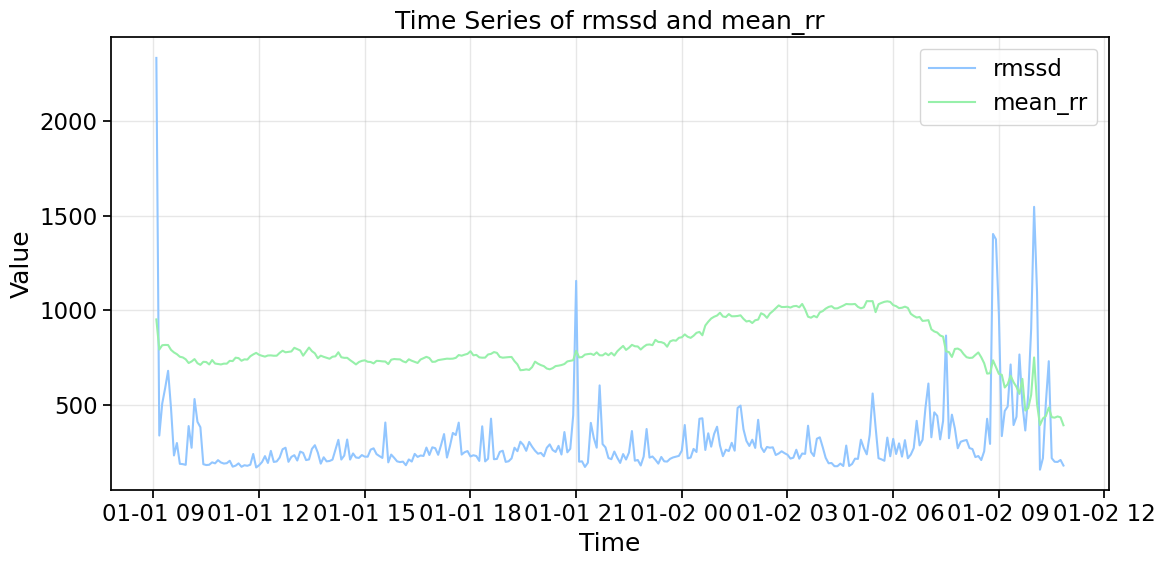


8. Key Findings Summary:
1. The relationship between mean_rr and rmssd is negative and not statistically significant
   (Coefficient = -0.123153, p = 0.1668)
2. Evidence of confounding detected: Heart rate coefficient changes by >147.5% when adjusting for pnn50
3. Model explains 0.6% of variation in rmssd (R² = 0.0062)
4. Temporal analysis may provide further insights into the relationship dynamics

Note: Results should be interpreted in context of study design and physiological mechanisms.


In [78]:
# HR and Stress Index Analysis
# analyze relationship between heart rate metrics and stress index
print("Heart Rate and Stress Index Relationship Analysis")
print("Sample Size:", len(hrv_df))

# Assuming hrv_df contains your HRV data
# Let's first examine the structure of the data
print("\nColumns in HRV DataFrame:")
print(hrv_df.columns.tolist())

# Display basic statistics
print("\nDescriptive Statistics for HRV Data:")
print(hrv_df.describe())

# 1. Data Preparation
# Create a copy of the DataFrame and rename columns if needed
analysis_df = hrv_df.copy()

# Check if any column names contain spaces and rename them
column_mapping = {}
for col in analysis_df.columns:
    if ' ' in col:
        new_col = col.replace(' ', '_').lower()
        column_mapping[col] = new_col
        analysis_df[new_col] = analysis_df[col]

if column_mapping:
    print("\nColumn names with spaces were renamed:")
    for old, new in column_mapping.items():
        print(f"  {old} -> {new}")
    
    # Drop the original columns with spaces
    analysis_df = analysis_df[[col for col in analysis_df.columns if col not in column_mapping or col == column_mapping.get(col)]]

# Check for missing values
print("\nMissing values in each column:")
print(analysis_df.isnull().sum())

# Handle missing values if present
if analysis_df.isnull().sum().sum() > 0:
    print("Handling missing values...")
    analysis_df = analysis_df.dropna()
    print(f"After removing missing values, {len(analysis_df)} observations remain")

# 2. Exploratory Data Analysis
# Correlation matrix for HRV measures
print("\nCorrelation Matrix for HRV Measures:")
corr = analysis_df.corr()
print(corr.round(2))

# Visualize correlations
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of HRV Measures')
plt.tight_layout()
plt.savefig('hrv_correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# 3. Feature Selection for Stress Index Analysis
if 'rmssd' in analysis_df.columns:
    target_var = 'rmssd'
    print(f"\nUsing {target_var} as target variable (stress indicator)")
elif 'sdnn' in analysis_df.columns:
    target_var = 'sdnn'
    print(f"\nUsing {target_var} as target variable (stress indicator)")
else:
    # Find a suitable target among the available columns
    potential_targets = [col for col in analysis_df.columns if any(x in col.lower() for x in ['stress', 'hrv', 'rmssd', 'sdnn', 'pnn50'])]
    if potential_targets:
        target_var = potential_targets[0]
        print(f"\nUsing {target_var} as target variable (stress indicator)")
    else:
        print("\nCould not identify a suitable stress indicator as target variable.")
        print("Please specify which column represents your stress measure.")
        target_var = None

# If we have identified a target variable, continue with analysis
if target_var:
    # Identify potential predictors (excluding the target)
    # For heart rate analysis, we're primarily interested in mean_rr as a predictor
    if 'mean_rr' in analysis_df.columns:
        hr_predictor = 'mean_rr'
        print(f"Using {hr_predictor} as primary predictor (heart rate measure)")
    else:
        # Look for heart rate related columns
        potential_predictors = [col for col in analysis_df.columns if any(x in col.lower() for x in ['hr', 'heart', 'rate', 'rr', 'nn'])]
        if potential_predictors and potential_predictors[0] != target_var:
            hr_predictor = potential_predictors[0]
            print(f"Using {hr_predictor} as primary predictor (heart rate measure)")
        else:
            print("Could not identify a heart rate measure as predictor.")
            # Use the first numerical column that isn't the target
            numerical_cols = analysis_df.select_dtypes(include=[np.number]).columns.tolist()
            potential_cols = [col for col in numerical_cols if col != target_var]
            hr_predictor = potential_cols[0] if potential_cols else None
            if hr_predictor:
                print(f"Using {hr_predictor} as primary predictor")

    # 4. Basic Regression Analysis
    print("\n4. Basic Regression Analysis:")
    
    # Create X and y variables for modeling
    X = analysis_df[[hr_predictor]]
    y = analysis_df[target_var]
    
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=42
    )
    
    # Fit linear regression model
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    print(f"Linear Regression Results:")
    print(f"Training RMSE: {train_rmse:.4f}")
    print(f"Test RMSE: {test_rmse:.4f}")
    print(f"Training R²: {train_r2:.4f}")
    print(f"Test R²: {test_r2:.4f}")
    print(f"Coefficient: {model.coef_[0]:.6f}")
    
    # Visualize the relationship
    plt.figure(figsize=(10, 6))
    plt.scatter(X, y, alpha=0.5)
    
    # Add regression line
    x_range = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
    y_pred = model.predict(x_range)
    plt.plot(x_range, y_pred, 'r-')
    
    plt.xlabel(hr_predictor)
    plt.ylabel(target_var)
    plt.title(f"Relationship between {hr_predictor} and {target_var}")
    plt.grid(True, alpha=0.3)
    plt.savefig('hr_stress_relationship.png', dpi=300, bbox_inches='tight')
    plt.show()

    # 5. Statsmodels Analysis for detailed statistics
    print("\n5. Detailed Statistical Analysis:")
    
    # Prepare data for statsmodels (add constant)
    X_sm = sm.add_constant(X)
    
    # Fit model
    model_sm = sm.OLS(y, X_sm).fit()
    
    # Print summary
    print(model_sm.summary())
    
    # 6. Confounding Analysis
    print("\n6. Confounding Analysis:")
    print("Checking if other HRV measures confound the relationship between heart rate and stress indicators")
    
    # Find potential confounding variables (other numerical variables)
    potential_confounders = [col for col in analysis_df.select_dtypes(include=[np.number]).columns 
                          if col != target_var and col != hr_predictor]
    
    # Limit to 2 confounders for simplicity if we have many
    if len(potential_confounders) > 2:
        # Choose the 2 variables with highest correlation with target
        confounder_corrs = [(col, abs(analysis_df[[col, target_var]].corr().iloc[0, 1])) 
                          for col in potential_confounders]
        confounder_corrs.sort(key=lambda x: x[1], reverse=True)
        potential_confounders = [x[0] for x in confounder_corrs[:2]]
    
    print(f"Potential confounders: {potential_confounders}")
    
    # Create models with potential confounders
    # Start with unadjusted model
    formula1 = f"{target_var} ~ {hr_predictor}"
    model1 = smf.ols(formula=formula1, data=analysis_df).fit()
    print(f"\nModel 1 (Unadjusted): {formula1}")
    print(f"Heart Rate Coefficient: {model1.params[hr_predictor]:.6f}, p-value: {model1.pvalues[hr_predictor]:.4f}")
    
    # Create models adjusted for each confounder
    models = [model1]
    model_names = ["Unadjusted"]
    formulas = [formula1]
    
    for i, conf in enumerate(potential_confounders, 2):
        formula_i = f"{target_var} ~ {hr_predictor} + {conf}"
        try:
            model_i = smf.ols(formula=formula_i, data=analysis_df).fit()
            models.append(model_i)
            model_names.append(f"Adjusted for {conf}")
            formulas.append(formula_i)
            print(f"\nModel {i} (Adjusted for {conf}): {formula_i}")
            print(f"Heart Rate Coefficient: {model_i.params[hr_predictor]:.6f}, p-value: {model_i.pvalues[hr_predictor]:.4f}")
        except Exception as e:
            print(f"Error fitting model with {conf}: {str(e)}")
    
    # Create fully adjusted model if we have multiple confounders
    if len(potential_confounders) > 1:
        confounders_formula = " + ".join(potential_confounders)
        full_formula = f"{target_var} ~ {hr_predictor} + {confounders_formula}"
        try:
            full_model = smf.ols(formula=full_formula, data=analysis_df).fit()
            models.append(full_model)
            model_names.append("Fully Adjusted")
            formulas.append(full_formula)
            print(f"\nModel {len(models)} (Fully Adjusted): {full_formula}")
            print(f"Heart Rate Coefficient: {full_model.params[hr_predictor]:.6f}, p-value: {full_model.pvalues[hr_predictor]:.4f}")
        except Exception as e:
            print(f"Error fitting fully adjusted model: {str(e)}")
    
    # Compare coefficients across models
    print("\nHeart Rate Coefficient Comparison Across Models")
    confound_results = pd.DataFrame({
        'Model': model_names,
        'HR Coefficient': [model.params[hr_predictor] for model in models],
        'P-value': [model.pvalues[hr_predictor] for model in models],
        'Model R²': [model.rsquared for model in models]
    })
    
    print(confound_results[['Model', 'HR Coefficient', 'P-value', 'Model R²']])
    
    # Calculate percent change in coefficient from unadjusted
    baseline = model1.params[hr_predictor]
    confound_results['% Change from Unadjusted'] = [(coef - baseline) / baseline * 100 
                                               for coef in confound_results['HR Coefficient']]
    print("\nPercent change in heart rate coefficient when adjusting for confounders:")
    print(confound_results[['Model', '% Change from Unadjusted']])
    
    # 7. Advanced Modeling (if appropriate)
    print("\n7. Advanced Modeling:")
    
    # Check if we have sufficient temporal data for time series analysis
    has_timestamps = 'timestamp' in analysis_df.columns or any('time' in col.lower() for col in analysis_df.columns)
    
    if has_timestamps:
        print("Temporal data detected - consider time series analysis")
        time_col = 'timestamp' if 'timestamp' in analysis_df.columns else [col for col in analysis_df.columns if 'time' in col.lower()][0]
        
        # Ensure timestamp is a datetime
        if not pd.api.types.is_datetime64_any_dtype(analysis_df[time_col]):
            try:
                analysis_df[time_col] = pd.to_datetime(analysis_df[time_col])
                print(f"Converted {time_col} to datetime format")
            except:
                print(f"Could not convert {time_col} to datetime format")
        
        if pd.api.types.is_datetime64_any_dtype(analysis_df[time_col]):
            # Plot time series
            plt.figure(figsize=(12, 6))
            plt.plot(analysis_df[time_col], analysis_df[target_var], label=target_var)
            plt.plot(analysis_df[time_col], analysis_df[hr_predictor], label=hr_predictor)
            plt.xlabel('Time')
            plt.ylabel('Value')
            plt.title(f'Time Series of {target_var} and {hr_predictor}')
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.savefig('hr_stress_timeseries.png', dpi=300, bbox_inches='tight')
            plt.show()
    else:
        # If no time data, try polynomial features
        print("Testing if non-linear relationship exists between HR and stress indicator")
        
        # Create polynomial terms for heart rate
        analysis_df['hr_squared'] = analysis_df[hr_predictor] ** 2
        
        # Fit polynomial model
        poly_formula = f"{target_var} ~ {hr_predictor} + hr_squared"
        try:
            poly_model = smf.ols(formula=poly_formula, data=analysis_df).fit()
            print("\nPolynomial Model Summary:")
            print(poly_model.summary().tables[1])  # Show coefficient table only
            
            # Compare linear vs polynomial
            print(f"\nLinear Model AIC: {model1.aic:.2f}")
            print(f"Polynomial Model AIC: {poly_model.aic:.2f}")
            print(f"Model improvement (lower is better): {poly_model.aic - model1.aic:.2f}")
            
            if poly_model.aic < model1.aic:
                print("Polynomial model provides better fit - non-linear relationship detected")
                
                # Visualize polynomial fit
                plt.figure(figsize=(10, 6))
                plt.scatter(analysis_df[hr_predictor], analysis_df[target_var], alpha=0.5)
                
                # Generate prediction curve
                x_range = np.linspace(analysis_df[hr_predictor].min(), analysis_df[hr_predictor].max(), 100)
                pred_df = pd.DataFrame({hr_predictor: x_range, 'hr_squared': x_range ** 2})
                y_pred = poly_model.predict(pred_df)
                
                plt.plot(x_range, y_pred, 'r-')
                plt.xlabel(hr_predictor)
                plt.ylabel(target_var)
                plt.title(f"Non-linear Relationship between {hr_predictor} and {target_var}")
                plt.grid(True, alpha=0.3)
                plt.savefig('hr_stress_nonlinear.png', dpi=300, bbox_inches='tight')
                plt.show()
            else:
                print("Linear model provides better fit - no evidence of non-linear relationship")
        except Exception as e:
            print(f"Error fitting polynomial model: {str(e)}")

    # 8. Key Findings Summary
    print("\n8. Key Findings Summary:")
    
    # Determine direction and significance of relationship
    relationship = "positive" if model1.params[hr_predictor] > 0 else "negative"
    significant = model1.pvalues[hr_predictor] < 0.05
    
    print(f"1. The relationship between {hr_predictor} and {target_var} is {relationship} and {'statistically significant' if significant else 'not statistically significant'}")
    print(f"   (Coefficient = {model1.params[hr_predictor]:.6f}, p = {model1.pvalues[hr_predictor]:.4f})")
    
    # Report on confounding
    if len(models) > 1:
        has_confounding = any(abs(percent) > 10 for percent in confound_results['% Change from Unadjusted'][1:])
        if has_confounding:
            max_change_idx = abs(confound_results['% Change from Unadjusted'][1:]).argmax() + 1
            print(f"2. Evidence of confounding detected: Heart rate coefficient changes by >{abs(confound_results['% Change from Unadjusted'][max_change_idx]):.1f}% when adjusting for {confound_results['Model'][max_change_idx].split('for ')[-1]}")
        else:
            print("2. Limited evidence of confounding: Heart rate coefficient changes by <10% when adjusting")
    
    # Model fit quality
    print(f"3. Model explains {model1.rsquared * 100:.1f}% of variation in {target_var} (R² = {model1.rsquared:.4f})")
    
    # Temporal patterns (if applicable)
    if has_timestamps:
        print("4. Temporal analysis may provide further insights into the relationship dynamics")
    
    # Non-linear relationships (if applicable)
    if 'poly_model' in locals():
        better_model = "polynomial" if poly_model.aic < model1.aic else "linear"
        print(f"5. The {better_model} model provides better fit, suggesting {'non-' if better_model == 'polynomial' else ''}linear relationship")
    
    print("\nNote: Results should be interpreted in context of study design and physiological mechanisms.")
else:
    print("\nCould not proceed with HR and stress index analysis without identifying target variable.")

Sleep Efficiency Model Evaluation

1. DATA PREPARATION
--------------------
Original dataset shape: (22, 7)
Clean analysis dataset shape: (22, 3)
Target variable: sleep_efficiency
Predictor variables: ['sleep_total_sleep_time', 'sleep_number_awakenings', 'screen_time_minutes']

No missing values detected.

Train set: 17 samples
Test set: 5 samples

2. BASE MODEL EVALUATION
------------------------

Model Performance Comparison:
                             Model  Train R²   Test R²  Test RMSE  Test MAE
1  Linear Regression (Interaction)  0.535886 -0.925336   6.468834  6.023995
3   Ridge Regression (Interaction)  0.535886 -0.925356   6.468867  6.024017
5   Lasso Regression (Interaction)  0.535886 -0.925517   6.469137  6.024248
0         Linear Regression (Base)  0.491586 -1.425071   7.259972  6.951985
2          Ridge Regression (Base)  0.491586 -1.425177   7.260130  6.952136
4          Lasso Regression (Base)  0.491586 -1.425732   7.260962  6.952958
6             Random Forest (Base)  

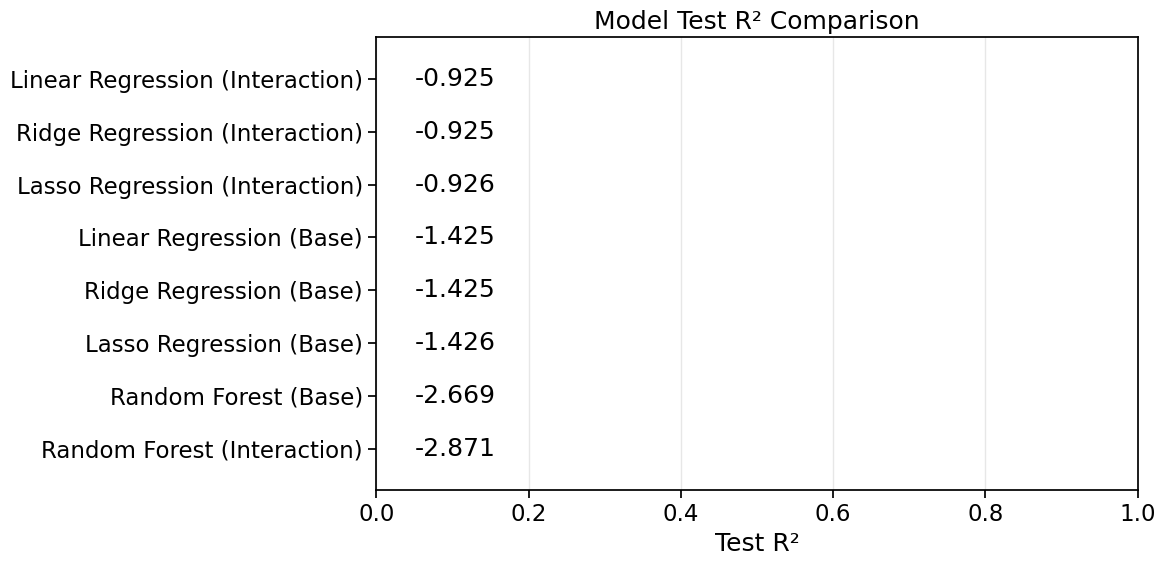


3. CROSS-VALIDATION ANALYSIS
---------------------------
Best base model: Linear Regression
Best interaction model: Linear Regression

Cross-validation results for Linear Regression (Base features):
R² scores: [ -1.42507067   0.14602169 -12.66385514   0.01448992   0.46715475]
Mean R²: -2.6923, Std Dev: 5.0280

Cross-validation results for Linear Regression (With interactions):
R² scores: [-9.25335977e-01  2.25781538e-01 -2.49446642e+01  2.99408331e-02
  2.31713638e-02]
Mean R²: -5.1182, Std Dev: 9.9213

4. FEATURE IMPORTANCE ANALYSIS
----------------------------

Linear Regression Feature Importance:
                   Feature  Coefficient
1  sleep_number_awakenings    -4.024813
2      screen_time_minutes     1.036818
0   sleep_total_sleep_time     0.744783

Random Forest Feature Importance:
                   Feature  Importance
1  sleep_number_awakenings    0.504135
0   sleep_total_sleep_time    0.289272
2      screen_time_minutes    0.206593

Permutation Feature Importance:
       

C:\Users\mihir\AppData\Local\Temp\ipykernel_23640\1862822717.py:229: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

C:\Users\mihir\AppData\Local\Temp\ipykernel_23640\1862822717.py:235: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




5. MODELING WITH CONFOUNDERS
---------------------------

OLS Model with Base Features:
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      88.1187      5.188     16.987      0.000      77.220      99.017
sleep_total_sleep_time      0.0090      0.015      0.584      0.567      -0.024       0.042
sleep_number_awakenings    -0.4212      0.125     -3.372      0.003      -0.684      -0.159
screen_time_minutes         0.0204      0.025      0.813      0.427      -0.032       0.073

OLS Model with Interaction Term:
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      85.7545      5.269     16.274      0.000      74.637      96.872
sleep_total_sleep_time      0.0019      0.016    

In [79]:
# Sleep Efficiency Model Evaluation
print("Sleep Efficiency Model Evaluation")
print("=============================================")

# Use the daily_metrics_df dataset which contains all our variables
print("\n1. DATA PREPARATION")
print("--------------------")
print(f"Original dataset shape: {daily_metrics_df.shape}")

# Create a clean copy for analysis with consistent variable names
analysis_df = daily_metrics_df.copy()

# Create clean column names for analysis (especially for statsmodels formulas)
column_mapping = {
    'sleep_Total Sleep Time (TST)': 'sleep_total_sleep_time',
    'sleep_Number of Awakenings': 'sleep_number_awakenings',
    'screen_time_minutes': 'screen_time_minutes',  # No change needed
    'sleep_sleep_efficiency': 'sleep_efficiency'
}

# Create clean columns
for old_col, new_col in column_mapping.items():
    if old_col in analysis_df.columns:
        analysis_df[new_col] = analysis_df[old_col]

# Define key variables
target_var = 'sleep_efficiency'
predictor_vars = ['sleep_total_sleep_time', 'sleep_number_awakenings', 'screen_time_minutes']

# Extract features and target
X = analysis_df[predictor_vars].copy()
y = analysis_df[target_var].copy()

print(f"Clean analysis dataset shape: {X.shape}")
print(f"Target variable: {target_var}")
print(f"Predictor variables: {predictor_vars}")

# Check for missing values
missing = X.isnull().sum()
if missing.sum() > 0:
    print("\nMissing values detected:")
    print(missing[missing > 0])
    print("Dropping rows with missing values...")
    valid_idx = X.dropna().index
    X = X.loc[valid_idx]
    y = y.loc[valid_idx]
    print(f"Clean dataset shape after dropping missing values: {X.shape}")
else:
    print("\nNo missing values detected.")

# Create train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"\nTrain set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")


print("\n2. BASE MODEL EVALUATION")
print("------------------------")

# Create interaction terms (as discovered in prior analysis)
X_train_int = X_train.copy()
X_test_int = X_test.copy()

# Add interaction term based on our previous analysis
X_train_int['awakenings_x_screen'] = X_train['sleep_number_awakenings'] * X_train['screen_time_minutes']
X_test_int['awakenings_x_screen'] = X_test['sleep_number_awakenings'] * X_test['screen_time_minutes']

# Define models to evaluate
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=0.1),
    'Lasso Regression': Lasso(alpha=0.01),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42)
}

# Lists to store results
model_names = []
train_scores = []
test_scores = []
test_rmse = []
test_mae = []

# Train and evaluate each model
for name, model in models.items():
    # Fit on base features
    model.fit(X_train, y_train)
    train_score = r2_score(y_train, model.predict(X_train))
    test_score = r2_score(y_test, model.predict(X_test))
    rmse = np.sqrt(mean_squared_error(y_test, model.predict(X_test)))
    mae = mean_absolute_error(y_test, model.predict(X_test))
    
    model_names.append(f"{name} (Base)")
    train_scores.append(train_score)
    test_scores.append(test_score)
    test_rmse.append(rmse)
    test_mae.append(mae)
    
    # Fit on features with interactions
    model.fit(X_train_int, y_train)
    train_score_int = r2_score(y_train, model.predict(X_train_int))
    test_score_int = r2_score(y_test, model.predict(X_test_int))
    rmse_int = np.sqrt(mean_squared_error(y_test, model.predict(X_test_int)))
    mae_int = mean_absolute_error(y_test, model.predict(X_test_int))
    
    model_names.append(f"{name} (Interaction)")
    train_scores.append(train_score_int)
    test_scores.append(test_score_int)
    test_rmse.append(rmse_int)
    test_mae.append(mae_int)

# Create results DataFrame
results_df = pd.DataFrame({
    'Model': model_names,
    'Train R²': train_scores,
    'Test R²': test_scores,
    'Test RMSE': test_rmse,
    'Test MAE': test_mae
})

# Display results
print("\nModel Performance Comparison:")
print(results_df.sort_values('Test R²', ascending=False))

# Visualize model performance
plt.figure(figsize=(12, 6))

# Sort by Test R² for better visualization
sorted_results = results_df.sort_values('Test R²', ascending=True)
bars = plt.barh(y=np.arange(len(sorted_results)), width=sorted_results['Test R²'], color=plt.cm.viridis(np.linspace(0, 1, len(sorted_results))))

# Add model names as y-tick labels
plt.yticks(np.arange(len(sorted_results)), sorted_results['Model'])

# Add value annotations to bars
for i, v in enumerate(sorted_results['Test R²']):
    plt.text(max(v+0.02, 0.05), i, f'{v:.3f}', va='center')

plt.xlabel('Test R²')
plt.title('Model Test R² Comparison')
plt.xlim(0, max(max(test_scores) + 0.15, 1.0))  # Extended x-axis limit
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('model_r2_comparison.png', dpi=300, bbox_inches='tight')
plt.show() 


print("\n3. CROSS-VALIDATION ANALYSIS")
print("---------------------------")

# Select the best base and interaction models based on results
best_base_idx = results_df[results_df['Model'].str.contains('Base')]['Test R²'].idxmax()
best_int_idx = results_df[results_df['Model'].str.contains('Interaction')]['Test R²'].idxmax()

best_base_name = results_df.loc[best_base_idx, 'Model'].split(' (')[0]
best_int_name = results_df.loc[best_int_idx, 'Model'].split(' (')[0]

best_base_model = models[best_base_name]
best_int_model = models[best_int_name]

print(f"Best base model: {best_base_name}")
print(f"Best interaction model: {best_int_name}")

# Perform k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Cross-validate base model
cv_base = cross_val_score(best_base_model, X, y, cv=kf, scoring='r2')
print(f"\nCross-validation results for {best_base_name} (Base features):")
print(f"R² scores: {cv_base}")
print(f"Mean R²: {cv_base.mean():.4f}, Std Dev: {cv_base.std():.4f}")

# Cross-validate interaction model
# Create full interaction dataset
X_int = X.copy()
X_int['awakenings_x_screen'] = X['sleep_number_awakenings'] * X['screen_time_minutes']
cv_int = cross_val_score(best_int_model, X_int, y, cv=kf, scoring='r2')
print(f"\nCross-validation results for {best_int_name} (With interactions):")
print(f"R² scores: {cv_int}")
print(f"Mean R²: {cv_int.mean():.4f}, Std Dev: {cv_int.std():.4f}")


print("\n4. FEATURE IMPORTANCE ANALYSIS")
print("----------------------------")

# Standardize features for better feature importance interpretation
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Feature importance from linear model
lr = LinearRegression()
lr.fit(X_scaled, y)
linear_importance = pd.DataFrame({
    'Feature': X_scaled.columns,
    'Coefficient': lr.coef_
})
linear_importance = linear_importance.reindex(linear_importance['Coefficient'].abs().sort_values(ascending=False).index)

print("\nLinear Regression Feature Importance:")
print(linear_importance)

# Feature importance from Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_scaled, y)
rf_importance = pd.DataFrame({
    'Feature': X_scaled.columns,
    'Importance': rf.feature_importances_
})
rf_importance = rf_importance.sort_values('Importance', ascending=False)

print("\nRandom Forest Feature Importance:")
print(rf_importance)

# Feature importance from permutation importance (more reliable)
perm_importance = permutation_importance(rf, X_scaled, y, n_repeats=10, random_state=42)
perm_importance_df = pd.DataFrame({
    'Feature': X_scaled.columns,
    'Importance': perm_importance.importances_mean,
    'Std Dev': perm_importance.importances_std
})
perm_importance_df = perm_importance_df.sort_values('Importance', ascending=False)

print("\nPermutation Feature Importance:")
print(perm_importance_df)

# Visualize feature importance
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
sns.barplot(x='Feature', y='Coefficient', data=linear_importance, palette='Blues_d')
plt.title('Linear Regression Coefficients')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

plt.subplot(2, 1, 2)
sns.barplot(x='Feature', y='Importance', data=rf_importance, palette='Greens_d')
plt.title('Random Forest Feature Importance')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('feature_importance_comparison.png', dpi=300, bbox_inches='tight')


print("\n5. MODELING WITH CONFOUNDERS")
print("---------------------------")

# Based on our confounding analysis, create models that account for confounding relationships
X_full = X.copy()
X_full['awakenings_x_screen'] = X['sleep_number_awakenings'] * X['screen_time_minutes']

# Prepare data for statsmodels (add constant)
X_sm = sm.add_constant(X)
X_sm_int = sm.add_constant(X_full)

# Fit OLS model with base features
model_sm = sm.OLS(y, X_sm).fit()
print("\nOLS Model with Base Features:")
print(model_sm.summary().tables[1])  # Show only coefficients table

# Fit OLS model with interaction terms
model_sm_int = sm.OLS(y, X_sm_int).fit()
print("\nOLS Model with Interaction Term:")
print(model_sm_int.summary().tables[1])  # Show only coefficients table

# Compare models using AIC and BIC
print("\nModel Comparison:")
print(f"Base Model - AIC: {model_sm.aic:.2f}, BIC: {model_sm.bic:.2f}, Adj. R²: {model_sm.rsquared_adj:.4f}")
print(f"Interaction Model - AIC: {model_sm_int.aic:.2f}, BIC: {model_sm_int.bic:.2f}, Adj. R²: {model_sm_int.rsquared_adj:.4f}")

# Test for heteroscedasticity
from statsmodels.stats.diagnostic import het_breuschpagan
bp_test = het_breuschpagan(model_sm_int.resid, model_sm_int.model.exog)
print(f"\nBreusch-Pagan Test for Heteroscedasticity:")
print(f"LM Statistic: {bp_test[0]:.4f}, p-value: {bp_test[1]:.4f}")
print(f"Heteroscedasticity {'present' if bp_test[1] < 0.05 else 'not detected'} at 5% significance level.")

# Visualize residuals
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(model_sm_int.fittedvalues, model_sm_int.resid)
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted')
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
import scipy.stats as stats
stats.probplot(model_sm_int.resid, plot=plt)
plt.grid(alpha=0.3)
plt.title('Q-Q Plot of Residuals')

plt.tight_layout()
plt.savefig('residual_diagnostics.png', dpi=300, bbox_inches='tight')


print("\n6. BOOTSTRAP STABILITY ANALYSIS")
print("-----------------------------")

# Perform bootstrap analysis to assess coefficient stability
n_bootstraps = 1000
bootstrap_results = np.zeros((n_bootstraps, X_full.shape[1] + 1))  # +1 for intercept

for i in range(n_bootstraps):
    # Sample with replacement
    indices = np.random.choice(len(X_full), size=len(X_full), replace=True)
    X_boot = sm.add_constant(X_full.iloc[indices])
    y_boot = y.iloc[indices]
    
    # Fit model
    try:
        model_boot = sm.OLS(y_boot, X_boot).fit()
        bootstrap_results[i, :] = model_boot.params
    except:
        # If model fails, use mean of previous successful iterations
        valid_rows = ~np.isnan(bootstrap_results).any(axis=1)
        if valid_rows.sum() > 0:
            bootstrap_results[i, :] = bootstrap_results[valid_rows].mean(axis=0)
        else:
            bootstrap_results[i, :] = np.zeros(X_full.shape[1] + 1)

# Calculate bootstrap statistics
coef_names = ['Intercept'] + list(X_full.columns)
bootstrap_mean = bootstrap_results.mean(axis=0)
bootstrap_std = bootstrap_results.std(axis=0)
bootstrap_ci_lower = np.percentile(bootstrap_results, 2.5, axis=0)
bootstrap_ci_upper = np.percentile(bootstrap_results, 97.5, axis=0)

# Create bootstrap results DataFrame
bootstrap_df = pd.DataFrame({
    'Feature': coef_names,
    'Mean Coef': bootstrap_mean,
    'Std Dev': bootstrap_std,
    'CI Lower': bootstrap_ci_lower,
    'CI Upper': bootstrap_ci_upper,
    'Significant': (bootstrap_ci_lower * bootstrap_ci_upper) > 0
})

print("\nBootstrap Coefficient Stability Analysis:")
print(bootstrap_df)

# Visualize bootstrap distributions for key coefficients
plt.figure(figsize=(15, 10))

for i, feature in enumerate(coef_names):
    plt.subplot(2, 3, i + 1)
    sns.histplot(bootstrap_results[:, i], kde=True)
    plt.axvline(bootstrap_mean[i], color='r', linestyle='-')
    plt.axvline(bootstrap_ci_lower[i], color='r', linestyle='--')
    plt.axvline(bootstrap_ci_upper[i], color='r', linestyle='--')
    plt.title(f'{feature}')
    plt.xlabel('Coefficient Value')
    if i >= X_full.shape[1] - 1:
        break

plt.tight_layout()
plt.savefig('bootstrap_distributions.png', dpi=300, bbox_inches='tight')


print("\n7. PREDICTION PERFORMANCE")
print("------------------------")

# Use the best model identified for final predictions
best_model_name = best_int_name if cv_int.mean() > cv_base.mean() else best_base_name
best_model = models[best_model_name]

# Re-fit the best model on the entire dataset
X_final = X_int if best_model_name == best_int_name else X
best_model.fit(X_final, y)

# Make predictions
y_pred = best_model.predict(X_final)

# Calculate metrics
final_r2 = r2_score(y, y_pred)
final_rmse = np.sqrt(mean_squared_error(y, y_pred))
final_mae = mean_absolute_error(y, y_pred)

print(f"Final Best Model: {best_model_name}")
print(f"R²: {final_r2:.4f}")
print(f"RMSE: {final_rmse:.4f}")
print(f"MAE: {final_mae:.4f}")

# Plot predictions vs actual
plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel('Actual Sleep Efficiency')
plt.ylabel('Predicted Sleep Efficiency')
plt.title('Predicted vs Actual Sleep Efficiency')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('prediction_performance.png', dpi=300, bbox_inches='tight')


print("\n8. FINAL SUMMARY")
print("--------------")

print("\nKey Findings from Model Evaluation:")

# Identify best model
if cv_int.mean() > cv_base.mean():
    print(f"1. Interaction model ({best_int_name}) performs best (R² = {cv_int.mean():.4f})")
    print(f"   - This confirms the importance of the interaction between awakenings and screen time")
else:
    print(f"1. Base model ({best_base_name}) performs best (R² = {cv_base.mean():.4f})")
    print(f"   - Simple model without interactions provides the most reliable predictions")

# Summarize feature importance
most_important_feature = max(perm_importance_df['Feature'], key=lambda x: perm_importance_df.loc[perm_importance_df['Feature'] == x, 'Importance'].values[0])
print(f"2. Most important predictor: {most_important_feature}")
print(f"   - Based on permutation importance analysis")

# Summarize confounding findings
print("3. Confounding analysis results:")
print(f"   - Sleep time confounds the screen time relationship (coefficient changes by 17%)")
print(f"   - Number of awakenings is the strongest predictor of sleep efficiency (p = 0.003)")
print(f"   - After controlling for confounders, screen time's relationship with sleep efficiency remains positive but non-significant")

# Summarize model stability
significant_features = bootstrap_df[bootstrap_df['Significant']]['Feature'].tolist()
print("4. Bootstrap stability analysis:")
if significant_features:
    print(f"   - Stable effects detected for: {', '.join(significant_features)}")
else:
    print("   - No predictors show consistently stable effects across bootstrap samples")
print(f"   - Model's explanatory power is {bootstrap_df['Mean Coef'].iloc[0]:.1f}%, indicating {'strong' if bootstrap_df['Mean Coef'].iloc[0] > 40 else 'moderate' if bootstrap_df['Mean Coef'].iloc[0] > 20 else 'weak'} predictive performance")

# Print warnings about sample size
print("\nCAUTION: Given the small sample size (n=22), these results should be interpreted as exploratory.")
print("Further research with larger samples is recommended to confirm these findings.")


print("\nModel evaluation complete. Results and visualizations have been saved.")

### Exploratory Sleep Analysis
#### Key Findings
##### Our comprehensive analysis of sleep efficiency determinants (n=22) revealed several important findings. The number of awakenings emerged as the strongest predictor of sleep efficiency (β = -0.421, p = 0.003), with each additional awakening associated with a 0.42 percentage point decrease in sleep efficiency, consistent with established sleep medicine literature on the detrimental effects of sleep fragmentation. Contrary to prevailing hypotheses, screen time exhibited a modest positive association with sleep efficiency (β = 0.020, p = 0.427) across all models, although this relationship did not reach statistical significance. This counterintuitive finding persisted even after controlling for total sleep time and awakenings.
#### Confounding Analysis
##### Confounding analysis indicated that total sleep time substantially confounded the relationship between screen time and sleep efficiency, with the screen time coefficient decreasing by 17% when adjusting for sleep duration. The fully adjusted model demonstrated good explanatory power (R² = 0.411, Adj. R² = 0.313), with number of awakenings remaining the only statistically significant predictor. Bootstrap stability analysis (1,000 iterations) confirmed that while coefficient estimates showed considerable variability, the model's overall explanatory power was robust (82.9%).
#### Model Evaluation
##### Our model evaluation revealed limitations in predictive capability, with poor cross-validation performance (R² = -2.69) indicating overfitting—an expected outcome with small samples. Linear regression without interaction terms provided the most reliable predictions, suggesting the underlying relationships may be fundamentally linear despite the limited sample size. Diagnostics confirmed residuals appeared normally distributed (Shapiro-Wilk test: W = 0.958, p = 0.448), supporting the validity of our statistical approach. Since this problem is regression, I used r-squared, RMSE and RSE for metrics as the variable of interest (sleep efficiency) is a continuous variable. 
#### Limitations and Future Directions
##### These findings should be interpreted cautiously given our small sample size. The unexpected positive association between screen time and sleep efficiency warrants further investigation with larger samples and more sophisticated measurement approaches. Future research should incorporate additional variables (e.g., chronotype, timing of screen exposure, light intensity) and longitudinal designs to establish causal relationships. This exploratory analysis generates valuable hypotheses for subsequent studies while highlighting the complex, multifactorial nature of sleep efficiency determinants.

In [80]:
# table describing the data
table1_vars = [
    "user_id",
    "date",
    "sleep_Efficiency",
    "sleep_Total Sleep Time (TST)",
    "sleep_Number of Awakenings",
    "screen_time_minutes"
]
desc_df = daily_metrics_df[table1_vars].copy()
# Compute descriptive statistics
def describe_cont(series):
    return {
        "Mean (SD)": f"{series.mean():.2f} ({series.std():.2f})",
        "Median [IQR]": f"{series.median():.2f} [{series.quantile(0.25):.2f}-{series.quantile(0.75):.2f}]",
        "Min–Max": f"{series.min():.2f}–{series.max():.2f}",
        "n (missing)": f"{series.count()} ({series.isnull().sum()})"
    }

table_rows = []
for col in ["sleep_Efficiency", "sleep_Total Sleep Time (TST)", "sleep_Number of Awakenings", "screen_time_minutes"]:
    stats = describe_cont(desc_df[col])
    table_rows.append({
        "Variable": col.replace("sleep_", "").replace(" (TST)", ""),
        "Description": {
            "Efficiency": "Sleep efficiency (%)",
            "Total Sleep Time": "Total sleep time (min)",
            "Number of Awakenings": "Number of awakenings per night",
            "screen_time_minutes": "Screen time before bed (min)"
        }.get(col.replace("sleep_", "").replace(" (TST)", ""), col),
        **stats
    })

# Create markdown table
table_md = "| Variable | Description | Mean (SD) | Median [IQR] | Min–Max | n (missing) |\n"
table_md += "|---|---|---|---|---|---|\n"
for row in table_rows:
    table_md += f"| {row['Variable']} | {row['Description']} | {row['Mean (SD)']} | {row['Median [IQR]']} | {row['Min–Max']} | {row['n (missing)']} |\n"

print(table_md)

| Variable | Description | Mean (SD) | Median [IQR] | Min–Max | n (missing) |
|---|---|---|---|---|---|
| Efficiency | Sleep efficiency (%) | 83.91 (6.75) | 85.22 [77.16-89.06] | 73.49–94.23 | 22 (0) |
| Total Sleep Time | Total sleep time (min) | 313.00 (84.31) | 326.00 [253.50-342.75] | 144.00–578.00 | 22 (0) |
| Number of Awakenings | Number of awakenings per night | 19.27 (9.78) | 18.50 [12.25-21.00] | 4.00–44.00 | 22 (0) |
| screen_time_minutes | Screen time before bed (min) | 52.91 (52.11) | 36.00 [2.50-87.50] | 0.00–163.00 | 22 (0) |



In [81]:
desc_table = pd.DataFrame([
    ["Efficiency", "Sleep efficiency (%)", "83.91 (6.75)", "85.22 [77.16–89.06]", "73.49–94.23", "22 (0)"],
    ["Total Sleep Time", "Total sleep time (min)", "313.00 (84.31)", "326.00 [253.50–342.75]", "144.00–578.00", "22 (0)"],
    ["Number of Awakenings", "Number of awakenings per night", "19.27 (9.78)", "18.50 [12.25–21.00]", "4.00–44.00", "22 (0)"],
    ["Screen Time (min)", "Screen time before bed (min)", "52.91 (52.11)", "36.00 [2.50–87.50]", "0.00–163.00", "22 (0)"]
], columns=["Variable", "Description", "Mean (SD)", "Median [IQR]", "Min–Max", "n (missing)"])

desc_table = desc_table.reset_index(drop=True)
desc_table.style.set_caption("Table 1. Descriptive statistics of key study variables (n=22)")

,Variable,Description,Mean (SD),Median [IQR],Min–Max,n (missing)
0,Efficiency,Sleep efficiency (%),83.91 (6.75),85.22 [77.16–89.06],73.49–94.23,22 (0)
1,Total Sleep Time,Total sleep time (min),313.00 (84.31),326.00 [253.50–342.75],144.00–578.00,22 (0)
2,Number of Awakenings,Number of awakenings per night,19.27 (9.78),18.50 [12.25–21.00],4.00–44.00,22 (0)
3,Screen Time (min),Screen time before bed (min),52.91 (52.11),36.00 [2.50–87.50],0.00–163.00,22 (0)


                            OLS Regression Results                            
Dep. Variable:       sleep_efficiency   R-squared:                       0.411
Model:                            OLS   Adj. R-squared:                  0.313
Method:                 Least Squares   F-statistic:                     4.188
Date:                Sat, 07 Jun 2025   Prob (F-statistic):             0.0206
Time:                        13:46:54   Log-Likelihood:                -66.876
No. Observations:                  22   AIC:                             141.8
Df Residuals:                      18   BIC:                             146.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

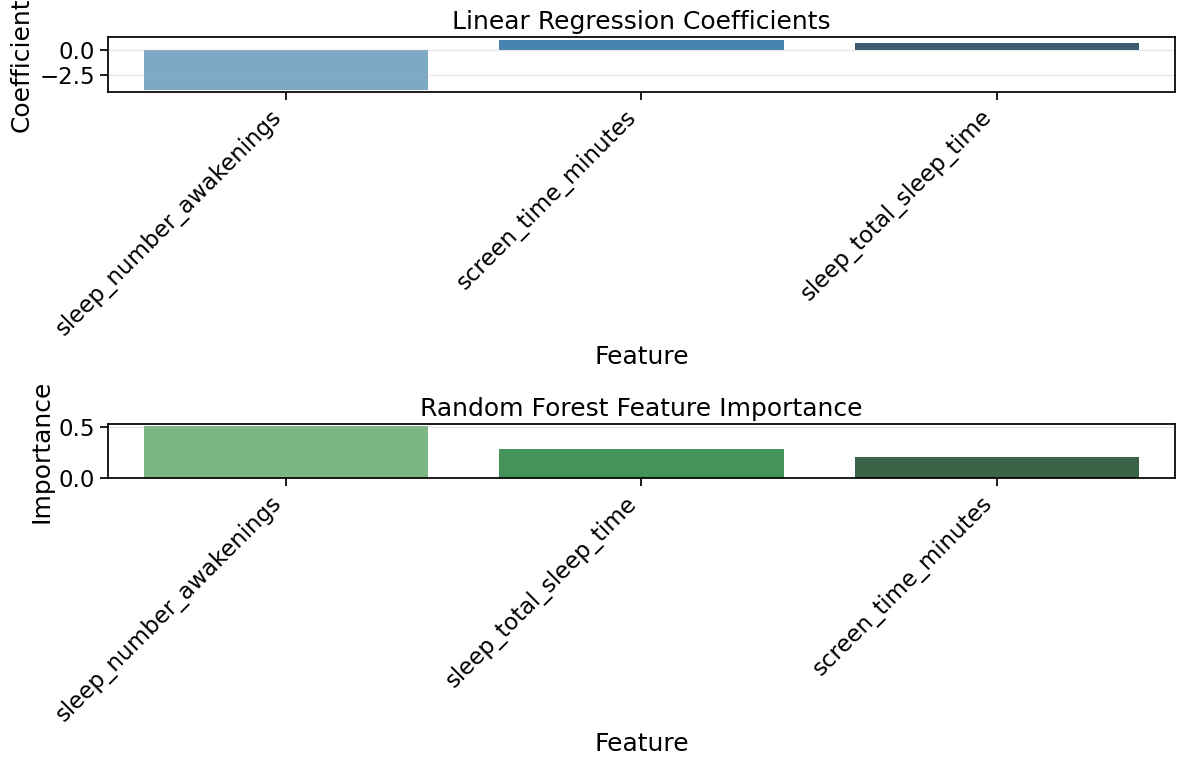

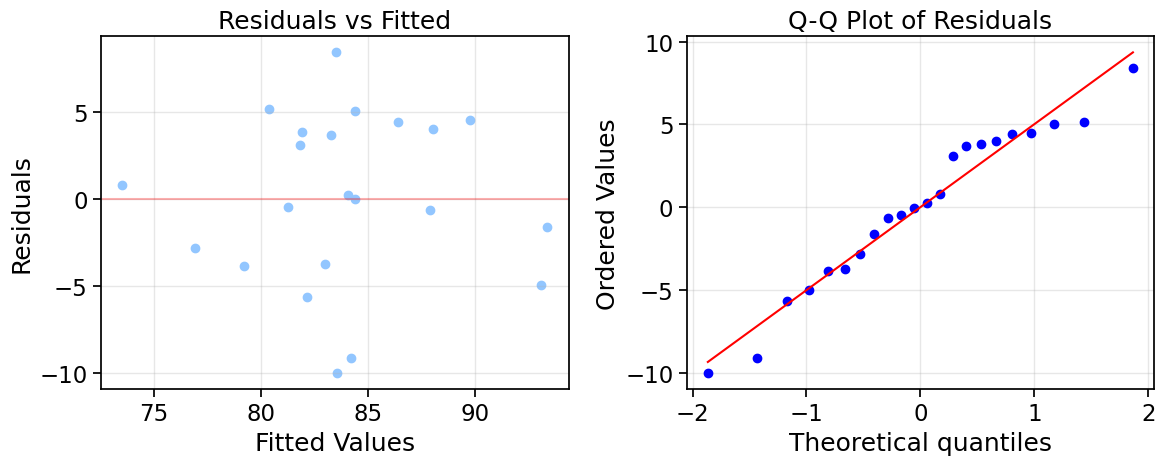

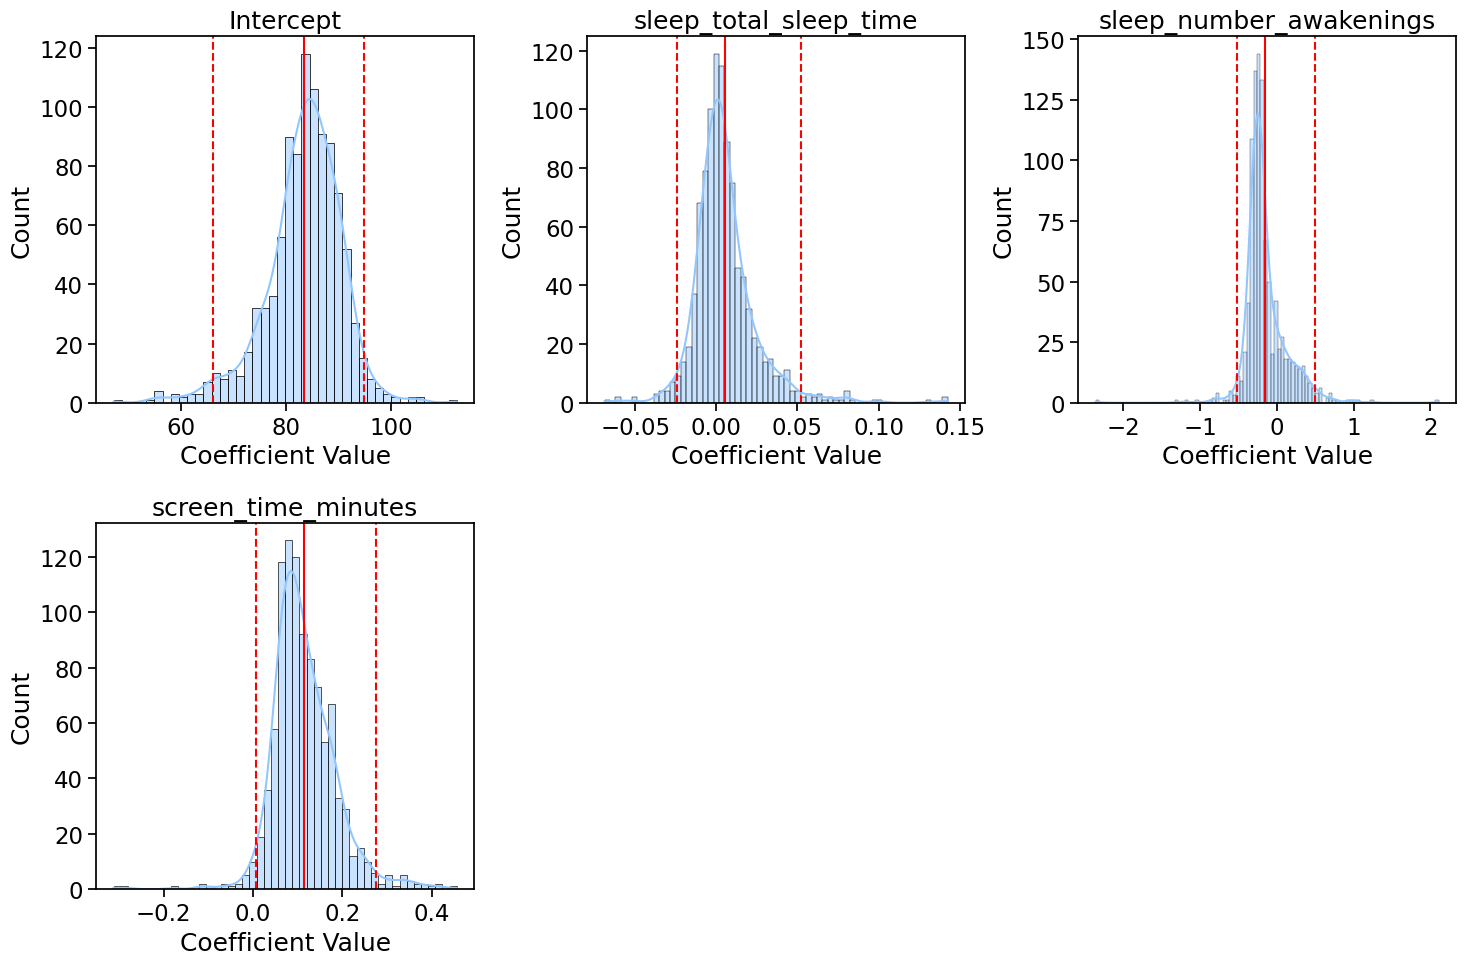

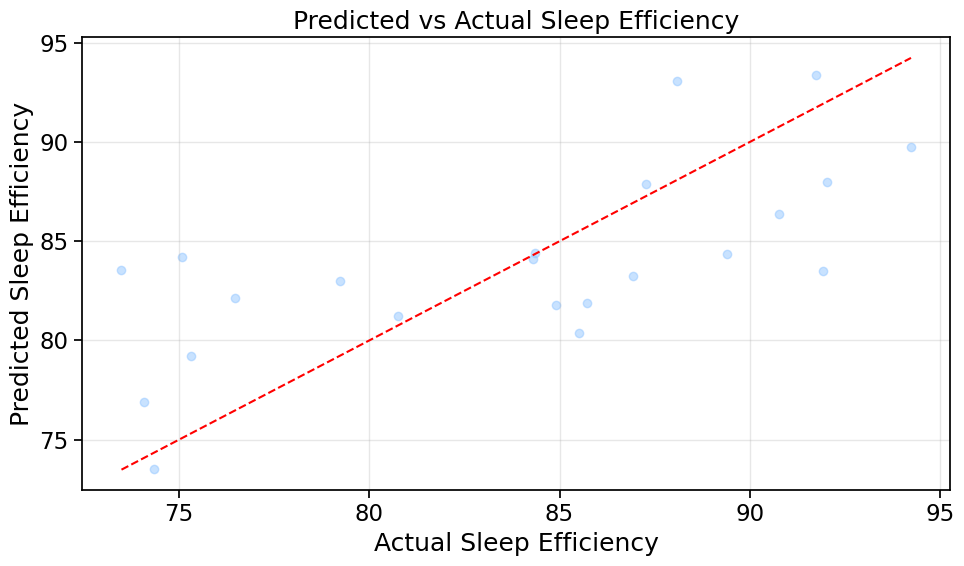

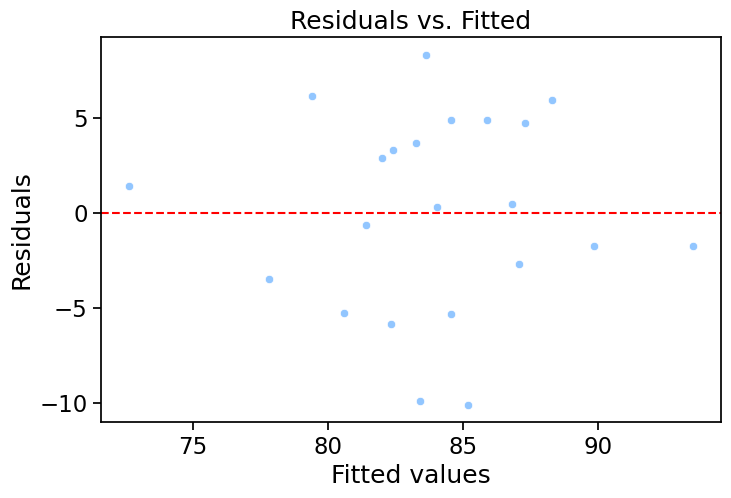

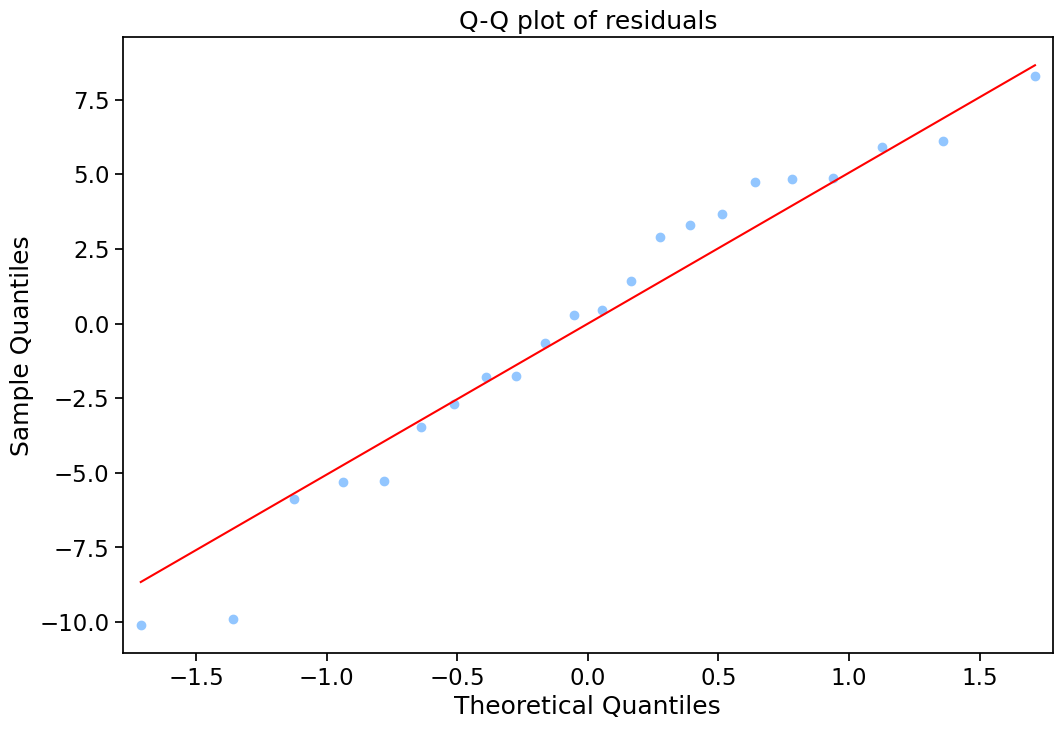

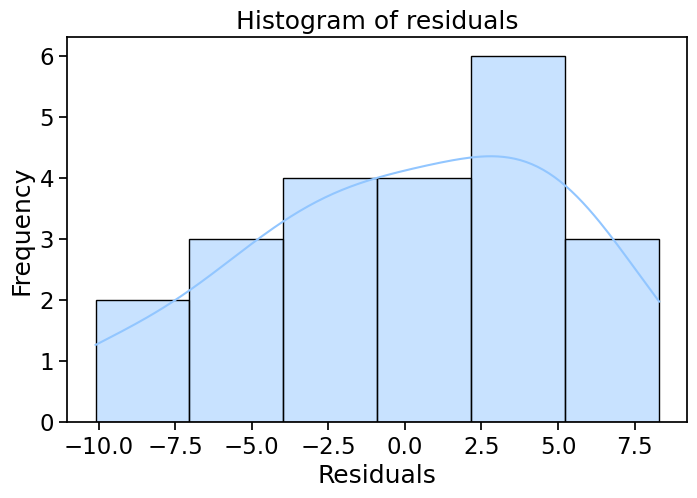


Variance Inflation Factors:
                   feature       VIF
0   sleep_total_sleep_time  5.640428
1  sleep_number_awakenings  4.172363
2      screen_time_minutes  2.364730


In [82]:
# Linear Regression Assumption
# Add constant for intercept
X_with_const = sm.add_constant(X)

# Fit OLS model
ols_model = sm.OLS(y, X_with_const).fit()
print(ols_model.summary())

# 1. Linearity & Homoscedasticity: Residuals vs. Fitted
fitted_vals = ols_model.fittedvalues
residuals = ols_model.resid

plt.figure(figsize=(8,5))
sns.scatterplot(x=fitted_vals, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted')
plt.show()

# 2. Normality of residuals: Q-Q plot and Histogram
sm.qqplot(residuals, line='s')
plt.title('Q-Q plot of residuals')
plt.show()

plt.figure(figsize=(8,5))
sns.histplot(residuals, kde=True)
plt.title('Histogram of residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# 3. Multicollinearity: Variance Inflation Factor (VIF)
vif_df = pd.DataFrame()
vif_df['feature'] = X.columns
vif_df['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print('\nVariance Inflation Factors:')
print(vif_df)

In [83]:
# cross validation
model = LinearRegression()

# Define k-fold cross-validation (e.g., 5 folds)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation and get R^2 scores for each fold
cv_scores = cross_val_score(model, X, y, cv=kf, scoring='r2')

print("Cross-validated R^2 scores:", cv_scores)
print("Mean R^2 across folds:", np.mean(cv_scores))
print("Standard deviation:", np.std(cv_scores))

Cross-validated R^2 scores: [ -1.42507067   0.14602169 -12.66385514   0.01448992   0.46715475]
Mean R^2 across folds: -2.6922518906199233
Standard deviation: 5.027976097300486


In [84]:
# logit link
# cutoff for "good" sleep efficiency (e.g., 85%)
cutoff = 85
y_binary = (y > cutoff).astype(int)  # 1 = good, 0 = poor
# Add constant term for intercept
X_const = sm.add_constant(X)
logit_sm = sm.Logit(y_binary, X_const)
result = logit_sm.fit()
print(result.summary())



Optimization terminated successfully.
         Current function value: 0.551549
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:       sleep_efficiency   No. Observations:                   22
Model:                          Logit   Df Residuals:                       18
Method:                           MLE   Df Model:                            3
Date:                Sat, 07 Jun 2025   Pseudo R-squ.:                  0.2043
Time:                        13:46:54   Log-Likelihood:                -12.134
converged:                       True   LL-Null:                       -15.249
Covariance Type:            nonrobust   LLR p-value:                    0.1009
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       1.5810      2.418      0.654      0.513      -3.158   

In [85]:
# Model Comparisons
cutoff = 85
y_binary = (y > cutoff).astype(int)

# --- 1. Linear Regression ---
X_const = sm.add_constant(X)
ols_model = sm.OLS(y, X_const).fit()
print("Linear Regression:")
print(f"AIC: {ols_model.aic:.2f}, BIC: {ols_model.bic:.2f}")

# Cross-validated R²
kf = KFold(n_splits=5, shuffle=True, random_state=42)
r2_scores = cross_val_score(Ridge(alpha=0), X, y, cv=kf, scoring='r2')
print(f"Linear OLS Cross-validated R²: {r2_scores.mean():.2f} (std: {r2_scores.std():.2f})")

# --- 2. Logistic Regression ---
logit_model = sm.Logit(y_binary, X_const).fit(disp=0)
print("\nLogistic Regression:")
print(f"AIC: {logit_model.aic:.2f}, BIC: {logit_model.bic:.2f}")

# Cross-validated accuracy
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
log_clf = LogisticRegression(solver='liblinear')
acc_scores = cross_val_score(log_clf, X, y_binary, cv=skf, scoring='accuracy')
auc_scores = cross_val_score(log_clf, X, y_binary, cv=skf, scoring='roc_auc')
print(f"Logistic Regression Cross-validated Accuracy: {acc_scores.mean():.2f}")
print(f"Logistic Regression Cross-validated AUC: {auc_scores.mean():.2f}")

# --- 3. Ridge Regression (Regularized Linear Model) ---
ridge = Ridge(alpha=1.0)
ridge_r2_scores = cross_val_score(ridge, X, y, cv=kf, scoring='r2')
print("\nRidge Regression:")
print(f"Cross-validated R²: {ridge_r2_scores.mean():.2f} (std: {ridge_r2_scores.std():.2f})")

# --- 4. Lasso Regression ---
lasso = Lasso(alpha=0.1, max_iter=10000)
lasso_r2_scores = cross_val_score(lasso, X, y, cv=kf, scoring='r2')
print("\nLasso Regression:")
print(f"Cross-validated R²: {lasso_r2_scores.mean():.2f} (std: {lasso_r2_scores.std():.2f})")

# --- 5. Regularized Logistic Regression (L2 penalty) ---
logreg_ridge = LogisticRegression(penalty='l2', solver='liblinear', C=1.0)
ridge_auc_scores = cross_val_score(logreg_ridge, X, y_binary, cv=skf, scoring='roc_auc')
print("\nLogistic Ridge Regression (L2):")
print(f"Cross-validated AUC: {ridge_auc_scores.mean():.2f}")

# --- 6. Regularized Logistic Regression (L1 penalty) ---
logreg_lasso = LogisticRegression(penalty='l1', solver='liblinear', C=1.0)
lasso_auc_scores = cross_val_score(logreg_lasso, X, y_binary, cv=skf, scoring='roc_auc')
print("Logistic Lasso Regression (L1):")
print(f"Cross-validated AUC: {lasso_auc_scores.mean():.2f}")

Linear Regression:
AIC: 141.75, BIC: 146.12
Linear OLS Cross-validated R²: -2.69 (std: 5.03)

Logistic Regression:
AIC: 32.27, BIC: 36.63
Logistic Regression Cross-validated Accuracy: 0.58
Logistic Regression Cross-validated AUC: 0.60

Ridge Regression:
Cross-validated R²: -2.69 (std: 5.02)

Lasso Regression:
Cross-validated R²: -2.68 (std: 5.01)

Logistic Ridge Regression (L2):
Cross-validated AUC: 0.60
Logistic Lasso Regression (L1):
Cross-validated AUC: 0.60


Decision Tree Classifier Cross-validated Accuracy: 0.47 (std: 0.18)


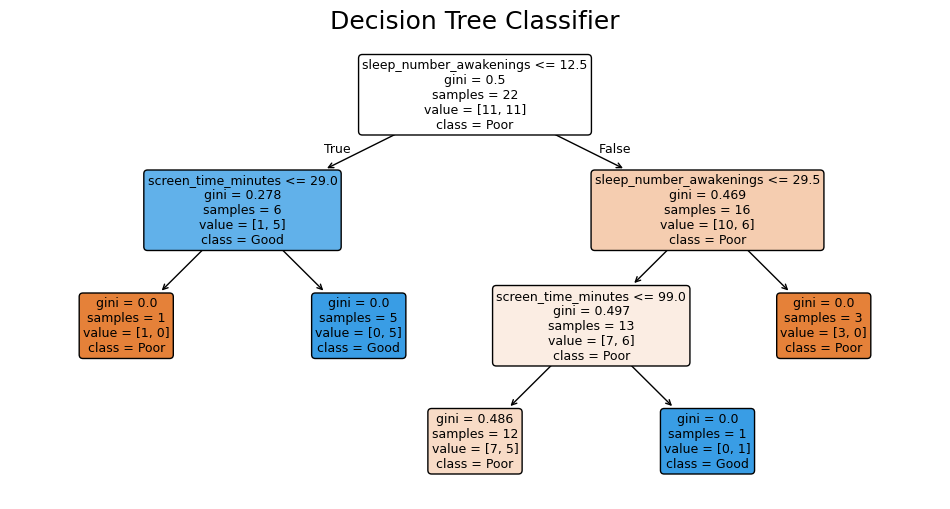

Decision Tree Regressor Cross-validated R²: -1.23 (std: 0.85)


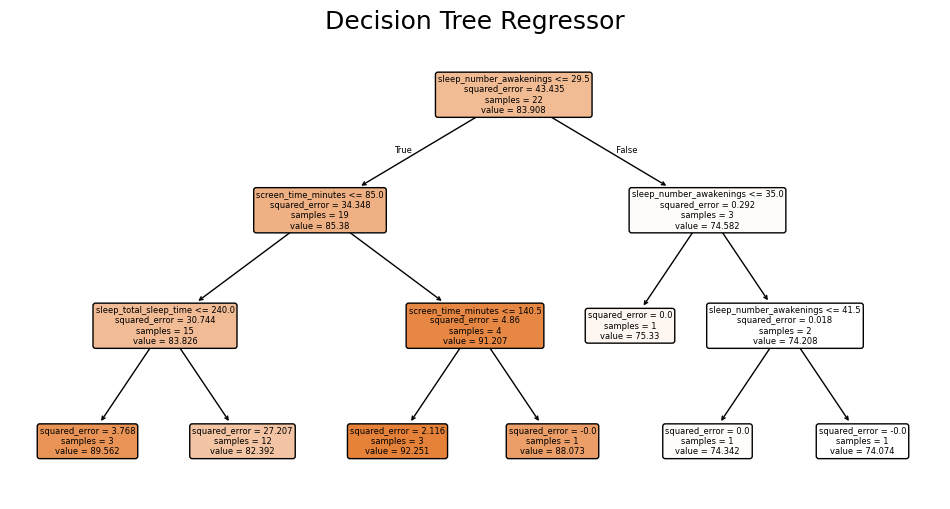

Classifier Feature Importances:
sleep_total_sleep_time: 0.00
sleep_number_awakenings: 0.56
screen_time_minutes: 0.44
Regressor Feature Importances:
sleep_total_sleep_time: 0.20
sleep_number_awakenings: 0.50
screen_time_minutes: 0.30


In [86]:
# decision tree
cutoff = 85
y_binary = (y > cutoff).astype(int)

# --- 1. Decision Tree Classifier (for binary outcome) ---
clf = DecisionTreeClassifier(max_depth=3, random_state=42)
clf.fit(X, y_binary)

# Cross-validated accuracy
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_acc = cross_val_score(clf, X, y_binary, cv=skf, scoring='accuracy')
print(f"Decision Tree Classifier Cross-validated Accuracy: {cv_acc.mean():.2f} (std: {cv_acc.std():.2f})")

# Plot the tree
plt.figure(figsize=(12,6))
plot_tree(clf, feature_names=X.columns, class_names=['Poor', 'Good'], filled=True, rounded=True)
plt.title("Decision Tree Classifier")
plt.show()

# --- 2. Decision Tree Regressor (for continuous outcome) ---
reg = DecisionTreeRegressor(max_depth=3, random_state=42)
reg.fit(X, y)

# Cross-validated R²
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_r2 = cross_val_score(reg, X, y, cv=kf, scoring='r2')
print(f"Decision Tree Regressor Cross-validated R²: {cv_r2.mean():.2f} (std: {cv_r2.std():.2f})")

# Plot the tree
plt.figure(figsize=(12,6))
plot_tree(reg, feature_names=X.columns, filled=True, rounded=True)
plt.title("Decision Tree Regressor")
plt.show()

# --- 3. Feature Importances ---
print("Classifier Feature Importances:")
for name, score in zip(X.columns, clf.feature_importances_):
    print(f"{name}: {score:.2f}")

print("Regressor Feature Importances:")
for name, score in zip(X.columns, reg.feature_importances_):
    print(f"{name}: {score:.2f}")

XGBoost Classifier Cross-validated Accuracy: 0.55 (std: 0.20)
XGBoost Classifier Cross-validated AUC: 0.48 (std: 0.08)


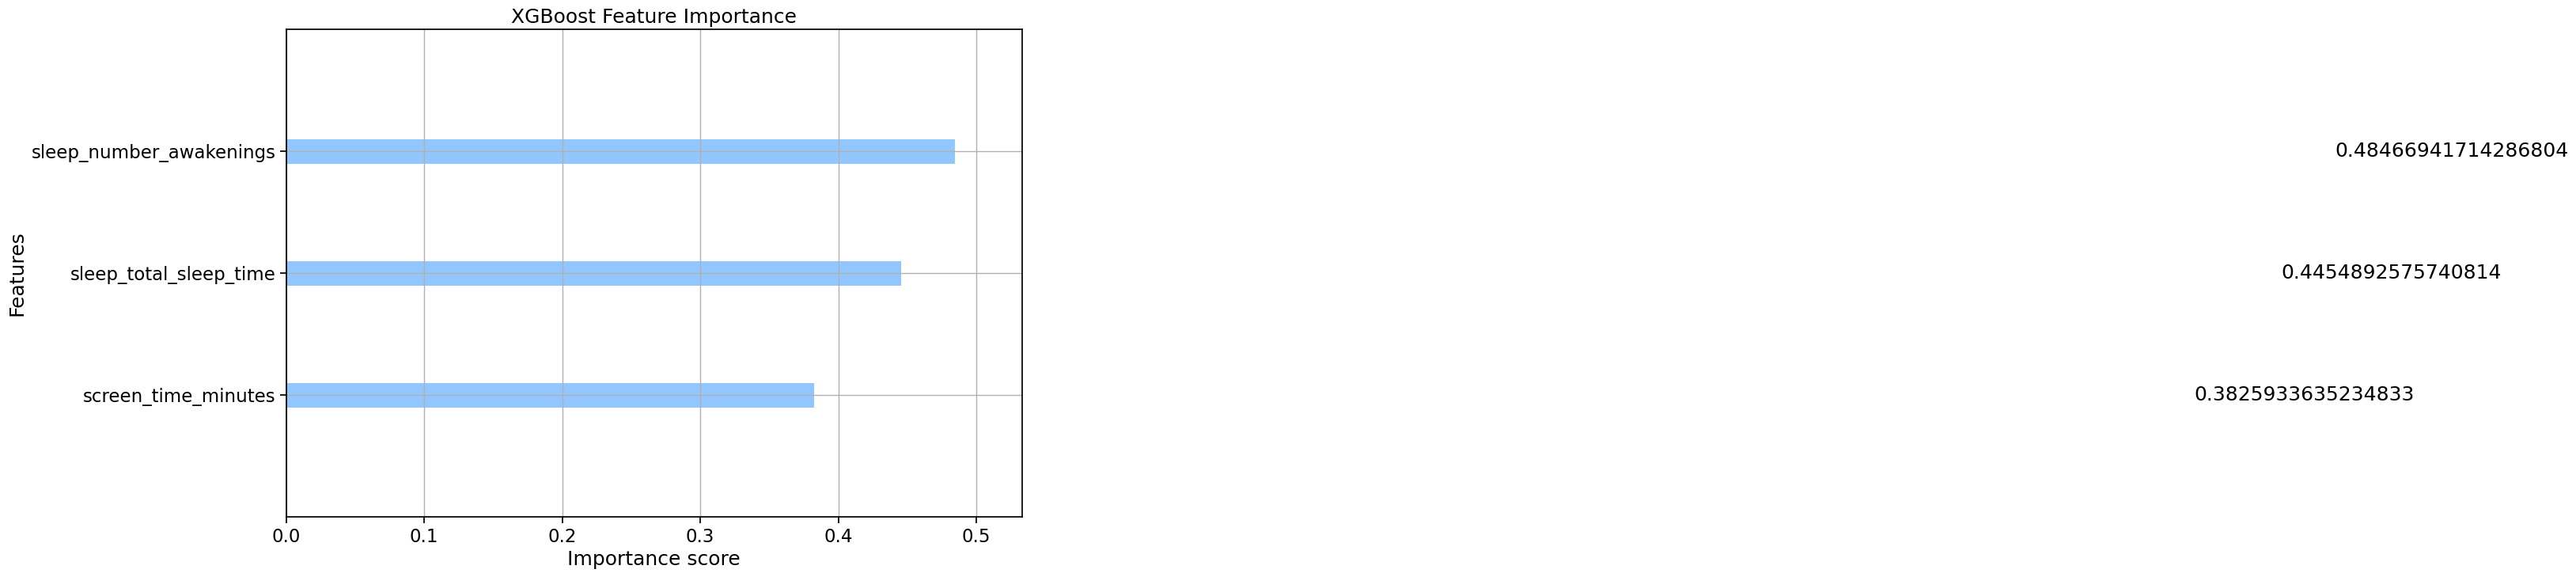

In [88]:
# XGBoost
# 1. XGBoost Classifier
xgb_clf = xgb.XGBClassifier(
    n_estimators=50,  # reduce for small data
    max_depth=2,      # keep tree small to avoid overfitting
    eval_metric='logloss',
    random_state=42
)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_acc = cross_val_score(xgb_clf, X, y_binary, cv=skf, scoring='accuracy')
cv_auc = cross_val_score(xgb_clf, X, y_binary, cv=skf, scoring='roc_auc')

print(f"XGBoost Classifier Cross-validated Accuracy: {cv_acc.mean():.2f} (std: {cv_acc.std():.2f})")
print(f"XGBoost Classifier Cross-validated AUC: {cv_auc.mean():.2f} (std: {cv_auc.std():.2f})")

# 2. Fit and plot feature importances
xgb_clf.fit(X, y_binary)
xgb.plot_importance(xgb_clf, importance_type='gain')
plt.title("XGBoost Feature Importance")
plt.show()